# **HR Analytics: Job Change of Data Scientists**


---



## Machine Learning and Data Mining project


---



### Sara Raccagni
### 2022/2023



# Introduction

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses. A lot of candidates sign up for the training, therefore, the company would know which ones really want to work for them after training or are looking for a new employment. The idea is to avoid, or at least reduce, the waste of time and money in training people who are not really interested in, as well as better manage course planning.

The purpose of this work is to understand which factors most affect candidates’ decisions, and to predict the probability that a candidate will work for the company or look for a new job. Several machine learning techniques, such as Decision Tree, Random Forest, Extra Trees, XGBoost, SVM and Neural Networks, are applied to a dataset of 19158 records. During the analysis, some plots are used to graph the outcomes obtained, and the evaluation is performed using a complete set of metrics such as Accuracy, Precision, Recall, Specificity, F1-score and AUC.

# Data

In [1]:
#%reset

# IMPORTS
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,recall_score,f1_score,roc_auc_score,precision_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from keras.regularizers import l2


In [2]:
# CONSTANTS
RANDOM_STATE = 3993
EPOCHS = 150
TRAIN_SIZE = 0.8
BATCH_SIZE = 32

## Data Import

The dataset has been downloaded from Kaggle dataset repository, to whom it was donated in 2021 by Arashnic Mobius.
https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists?datasetId=1019790 

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download arashnic/hr-analytics-job-change-of-data-scientists
! unzip hr-analytics-job-change-of-data-scientists.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/295k [00:00<?, ?B/s]
100% 295k/295k [00:00<00:00, 63.7MB/s]
Archive:  hr-analytics-job-change-of-data-scientists.zip
  inflating: aug_test.csv            
  inflating: aug_train.csv           
  inflating: sample_submission.csv   


It includes a training set of 19158 records with 14 attributes each, and a test set provided for the Kaggle submission. The latter consists of 2129 records where target values are not included since predicting them is a task of this work. 
They are merged into a single dataset in order to apply all data preprocessing techniques directly to both. 

In [4]:
train = pd.read_csv("aug_train.csv")
train.shape

(19158, 14)

In [5]:
test_kaggle = pd.read_csv("aug_test.csv") #test set for the Kaggle submission
test_kaggle['target'] = 0 #this test set doen't have the target value, therfore I assign 0 to all records
test_kaggle.shape

(2129, 14)

In [6]:
#The concat() function appends the rows from the two Dataframes to create a new Dataframe. When 
#you list this out you can see that all of the data rows are there, however, there is a problem 
#with the index: when you concatenate the Dataframes the indexes are also concatenated resulting 
#in duplicate entries. This is a problem if you need to access a row by its index. You can avoid
#the problem with ignore_index=True.
data = pd.concat([train, test_kaggle], ignore_index=True)

data

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15,0.0
21283,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30,0.0
21284,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18,0.0
21285,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84,0.0


## Dataset Description

This section provides a detailed description of each attribute in order to better understand their meaning.

**Input attributes**

1. Enrollee_id: unique candidate's ID
2. City: city code
3. City_development_index: developement index of the city
4. Gender: candidate's gender
5. Relevent_experience: candidate’s relevant experience
6. Enrolled_university: type of university enrollment if any
7. Education_level: candidate’s education level
8. Major_discipline: candidate’s major education discipline
9. Experience: candidate’s total experience in years
10. Company_size: number of employees in the current employer’s company
11. Company_type: type of current employer’s company
12. Last_new_job: difference in years between previous and current job
13. Training_hours: training hours completed

All this information about demographics, education and experiences was collected through the applicants' enrollment form.

**Target**

- Not looking for job change - 0
- Looking for a job change - 1

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In this dataset we can distinguish two types of features: 


1.   Features characterized by categorical values (nominal, ordinal and binary)
2.   Features characterized by numerical values



In [8]:
numerical = [feature for feature in train.columns if train.dtypes[feature] != 'object' and feature != 'target']
categorical = [feature for feature in train.columns if train.dtypes[feature] == 'object' or feature == 'target']

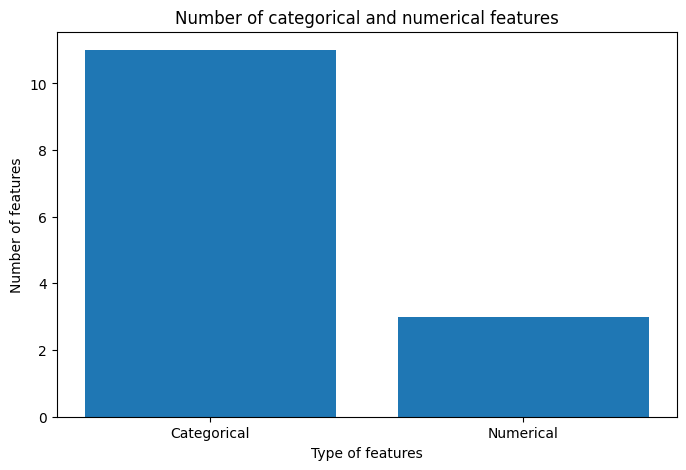

In [9]:
y_pos = ["Categorical","Numerical"]
f=plt.subplots(figsize=(8,5))
plt.bar(y_pos, [len(categorical),len(numerical)], align='center')
plt.ylabel('Number of features')
plt.xlabel('Type of features')
plt.title('Number of categorical and numerical features')
plt.show()

Categorical features, on the left, are 11 and numerical features, on the right, are 3.

**Categorial attributes**

In [10]:
#11 categorical attributes
categorical

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'target']

In [11]:
for obj in categorical:
  print("%d unique values of %s:"% (data[obj].nunique(),obj) ,data[obj].unique())

123 unique values of city: ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'city_81' 'cit

In [12]:
#From a first reading, we can see that all values of the feature "company_size" have a similar shape (X-Y) exept '10/49'
train['company_size'] = train['company_size'].replace('10/49', '10-49')
test_kaggle['company_size'] = test_kaggle['company_size'].replace('10/49', '10-49')

In [13]:
#Target is expressed as a float value (0.0 or 1.0). For a better readibility we change the type.
train['target']= train['target'].astype('int')
test_kaggle['target']= test_kaggle['target'].astype('int')

In [14]:
data = pd.concat([train, test_kaggle], ignore_index=True)
#data

**Numerical attributes**

In [15]:
#3 numerical attributes
numerical

['enrollee_id', 'city_development_index', 'training_hours']

In [16]:
for num in numerical:
  print("%d unique values of %s:"% (data[num].nunique(),num) ,np.sort(data[num].unique()))

21287 unique values of enrollee_id: [    1     2     3 ... 33377 33379 33380]
93 unique values of city_development_index: [0.448 0.479 0.487 0.493 0.512 0.516 0.518 0.527 0.55  0.555 0.556 0.558
 0.563 0.579 0.624 0.625 0.64  0.645 0.647 0.649 0.664 0.666 0.68  0.682
 0.689 0.691 0.693 0.698 0.701 0.722 0.725 0.727 0.73  0.735 0.738 0.739
 0.74  0.742 0.743 0.745 0.754 0.762 0.763 0.764 0.766 0.767 0.769 0.775
 0.776 0.78  0.781 0.788 0.789 0.794 0.795 0.796 0.802 0.804 0.807 0.824
 0.827 0.83  0.836 0.84  0.843 0.847 0.848 0.855 0.856 0.865 0.866 0.878
 0.884 0.887 0.89  0.893 0.895 0.896 0.897 0.898 0.899 0.903 0.91  0.913
 0.915 0.92  0.921 0.923 0.924 0.925 0.926 0.939 0.949]
241 unique values of training_hours: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  6

## Feature Distribution

In this section several plots are used to analyze the feature distribution. It can be useful to understand how the values of each feature are distributed within the dataset and how they are splitted between the target classes 0 and 1. Moreover, some of this information will be used in the data preprocessing section during the handling of missing values and feature scaling. 

In [17]:
print(train.columns.to_list())

['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'target']


NB: During this analysis, ID and city code attributes will not be taken into consideration since they are not so relevant for the task. Later, in the next section, we will go into more detail about their removal from the dataset.


In [18]:
def countplot(column,y):
  value_count = train[column].value_counts()
  print(value_count)

  plt.figure(figsize = (9,5))
  sns.countplot(x=train[column],order=value_count.index)
  plt.title(column+" distribution")
  for i in range(value_count.shape[0]):
      plt.text( 
              i,
              value_count[i]+y, #it's necessary to move the percentage above the top of the bar
              str('{percentage:.1%}'.format(percentage=value_count[i] / train[column].count())),
              ha='center',
              va = 'top')
  plt.show()

In [19]:
def piechart(column):
  print(pd.crosstab(train[column], train['target'], margins=True))

  count = train[train["target"]==0.0][column].value_counts()
  count_tot= train[column].value_counts()
    
  fig, axs = plt.subplots(1,train[column].nunique()) 
  fig.set_size_inches(20, 10)
  mylabels = ["0", "1"] 

  for elem in range(count.shape[0]):
    y = np.array([count[elem], count_tot[elem]-count[elem]])
    axs[elem].pie(y, labels = mylabels,autopct='%1.1f%%')
    axs[elem].set_title(count.index[elem])
  plt.show()

In [20]:
def plots(column,y):
  countplot(column,y)
  piechart(column)



### Categorial

Let’s have a look at categorical features where count plots and pie charts are used for the analysis.

**Gender**

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64


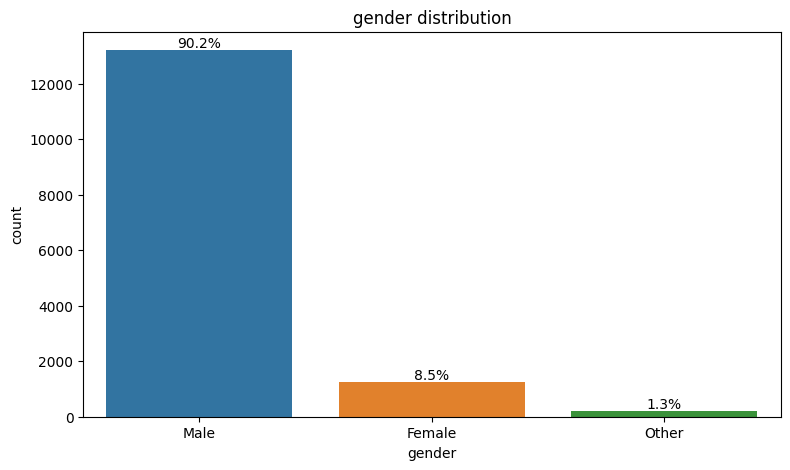

target      0     1    All
gender                    
Female    912   326   1238
Male    10209  3012  13221
Other     141    50    191
All     11262  3388  14650


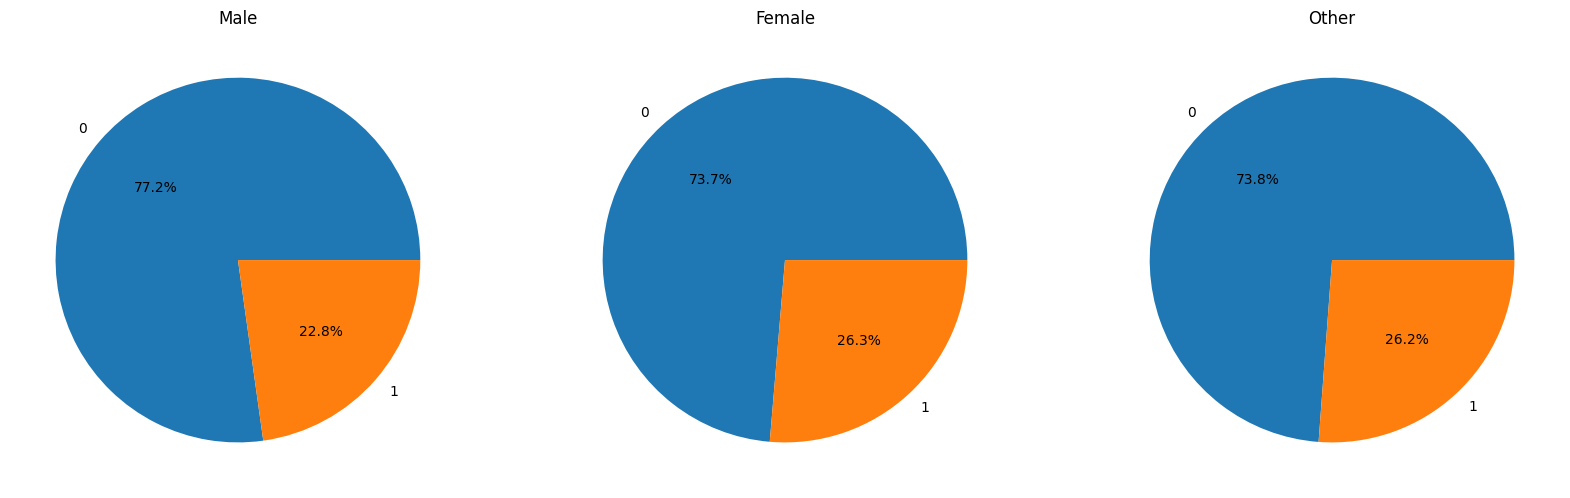

In [21]:
plots('gender',500)

The 90% of the dataset consists of men, around 9% of women, while a very small percentage belongs to other categories. In all cases the number of people who will not look for a new job is higher (around 75%).

**Relevant Experience**

Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64


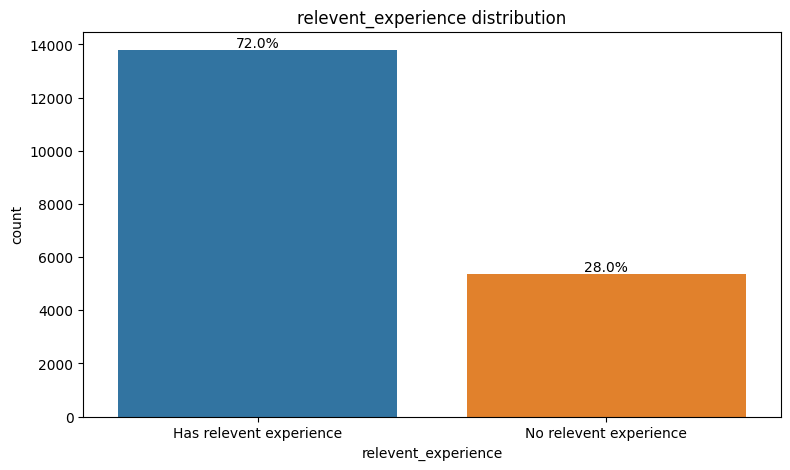

target                       0     1    All
relevent_experience                        
Has relevent experience  10831  2961  13792
No relevent experience    3550  1816   5366
All                      14381  4777  19158


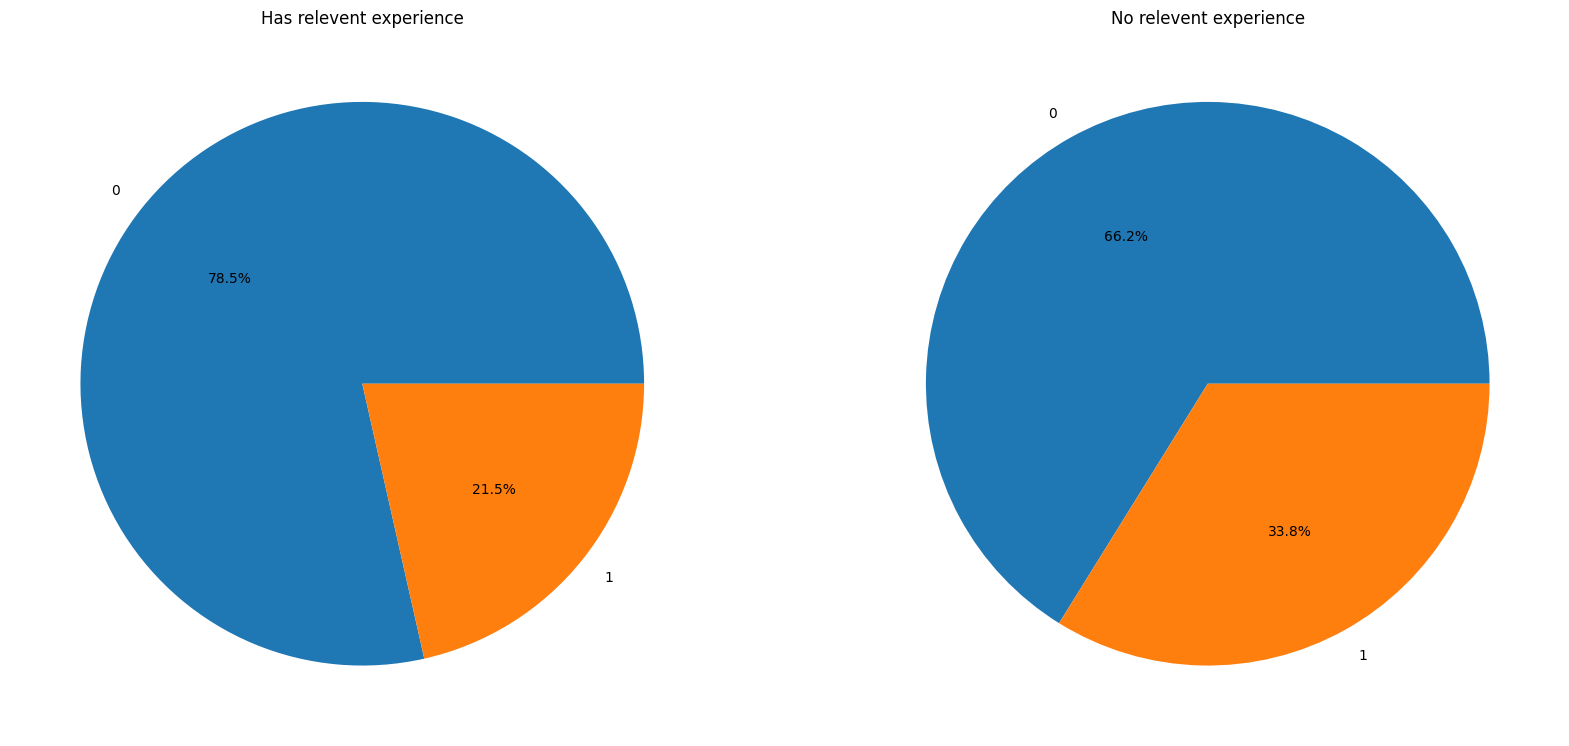

In [22]:
plots('relevent_experience',500)

Dataset consists of more people that have relevant experience in the field (72%). The percentage of those who will not look for a new job is higher among the ones with relevant experience (around 79%) than the ones without (around 66%).

**Enrolled University**

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64


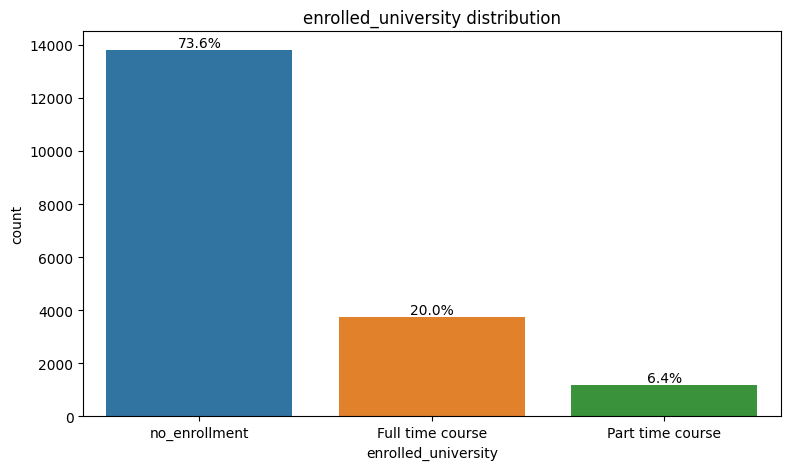

target                   0     1    All
enrolled_university                    
Full time course      2326  1431   3757
Part time course       896   302   1198
no_enrollment        10896  2921  13817
All                  14118  4654  18772


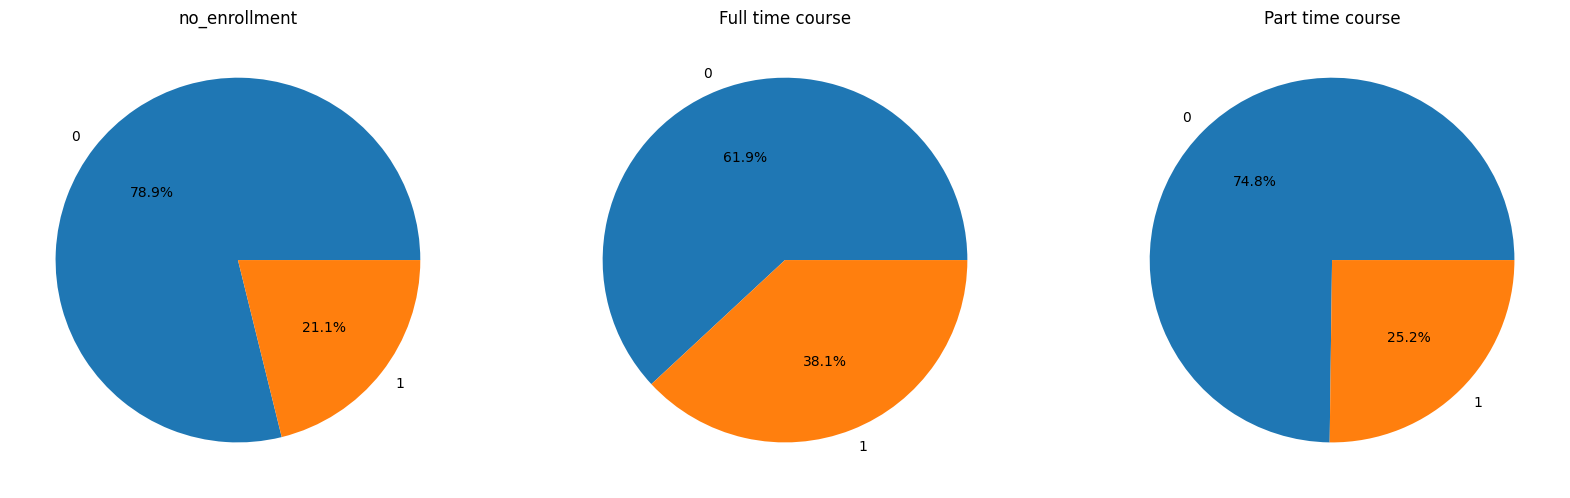

In [23]:
plots('enrolled_university',500)

Most of the candidates are not attending the university and the majority of them are really interested in the job. There is a group of people who are enrolled full time and among them the target distribution is a little more balanced: 38% will look for a new job, 62% will not. This trend is understandable since usually a full time student doesn’t have enough time to both study and work or doesn’t want to. There is also a small group of part time students where 75% of them will not look for a new job.

**Education Level**

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64


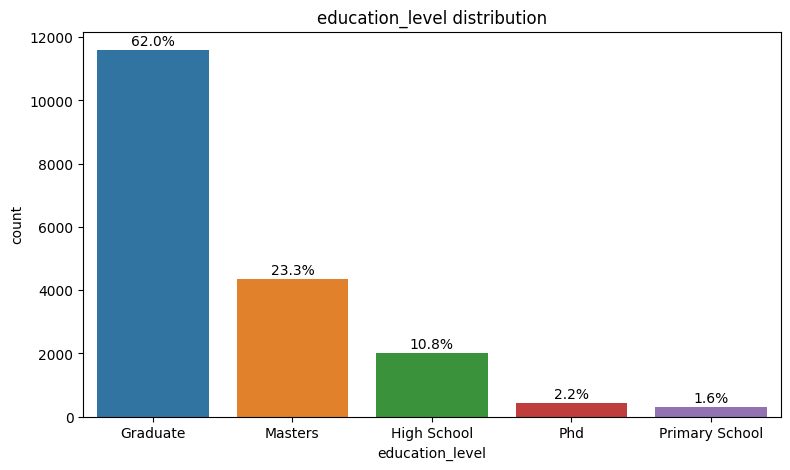

target               0     1    All
education_level                    
Graduate          8353  3245  11598
High School       1623   394   2017
Masters           3426   935   4361
Phd                356    58    414
Primary School     267    41    308
All              14025  4673  18698


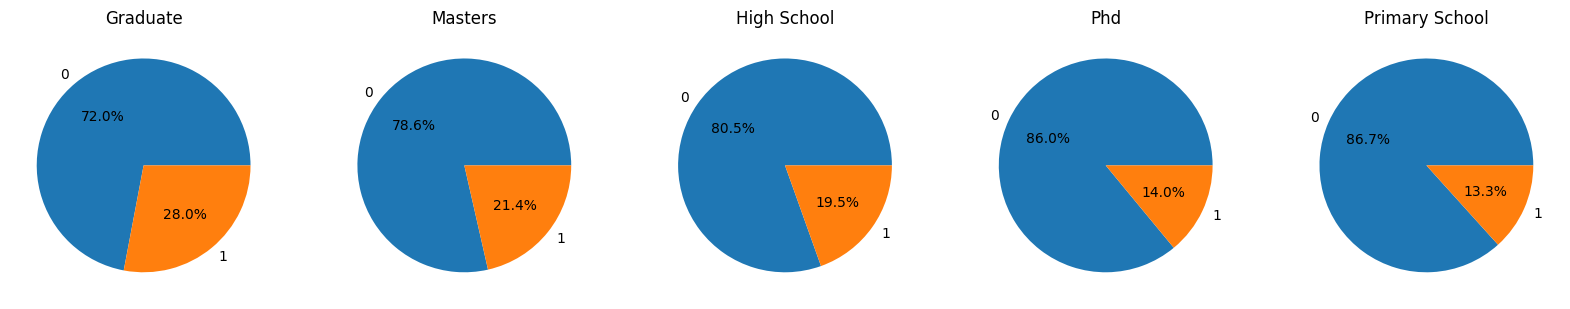

In [24]:
plots('education_level',500)

Most of the samples relate to people who have a bachelor or a master degree since they are candidates for a job that requires a high education level. There is a group of people from high school and two really small from phd and primary school. The percentage of the ones who are really interested in the job follows the opposite trend: it’s higher in groups with few samples and lower in groups with many samples.

**Major Discipline**

STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64


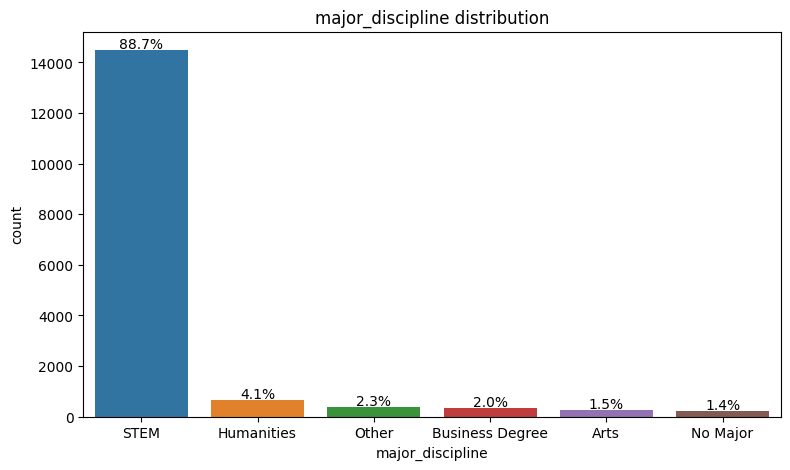

target                0     1    All
major_discipline                    
Arts                200    53    253
Business Degree     241    86    327
Humanities          528   141    669
No Major            168    55    223
Other               279   102    381
STEM              10701  3791  14492
All               12117  4228  16345


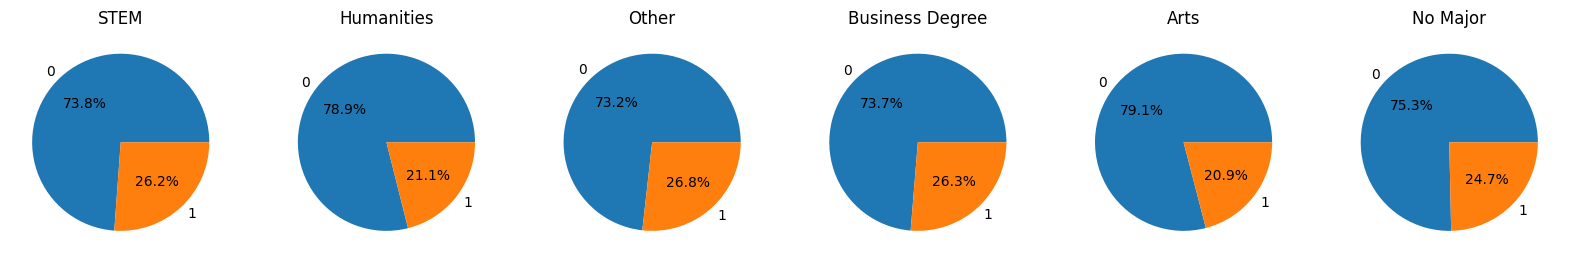

In [25]:
plots('major_discipline',500)

It’s clear that most of the candidates have a STEM discipline (Science, Technology, Engineering and Mathematics) as their major discipline. This result is understandable since the company we are talking about is active in Big Data and Data Science. The percentage of those who will look for a new job remains between 21% and 27% for all cases.

**Experience**

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64


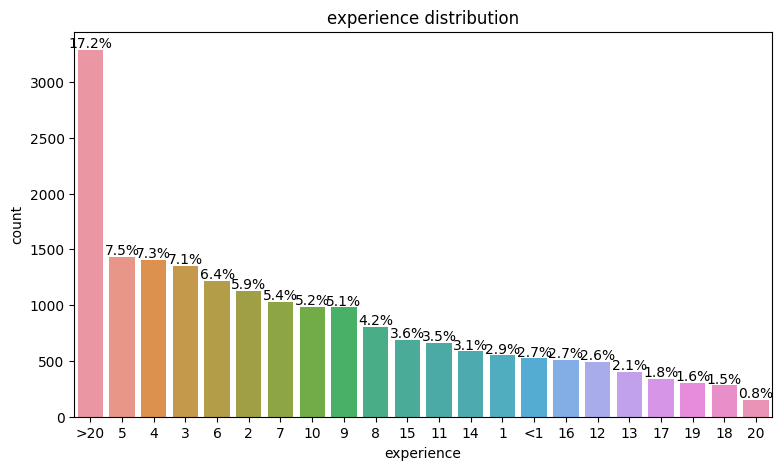

target          0     1    All
experience                    
1             316   233    549
10            778   207    985
11            513   151    664
12            402    92    494
13            322    77    399
14            479   107    586
15            572   114    686
16            436    72    508
17            285    57    342
18            237    43    280
19            251    53    304
2             753   374   1127
20            115    33    148
3             876   478   1354
4             946   457   1403
5            1018   412   1430
6             873   343   1216
7             725   303   1028
8             607   195    802
9             767   213    980
<1            285   237    522
>20          2783   503   3286
All         14339  4754  19093


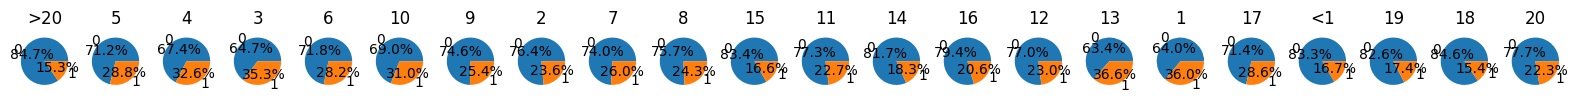

In [26]:
plots('experience',120)

The distribution of candidates' total experience, expressed in the number of years, takes a gradual downward trend, except for the case with more than 20 years of experience. It doesn’t seem possible to deduce a specific order or criterion by which the several values are positioned in the plot. The percentage of those who will look for a new job goes from 15.3% (min value), that is related to people with more than 20 years of experience, to 36.6% (max value), that is related to the ones with 13 years.

**Company Size**

50-99        3083
100-500      2571
10000+       2019
10-49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64


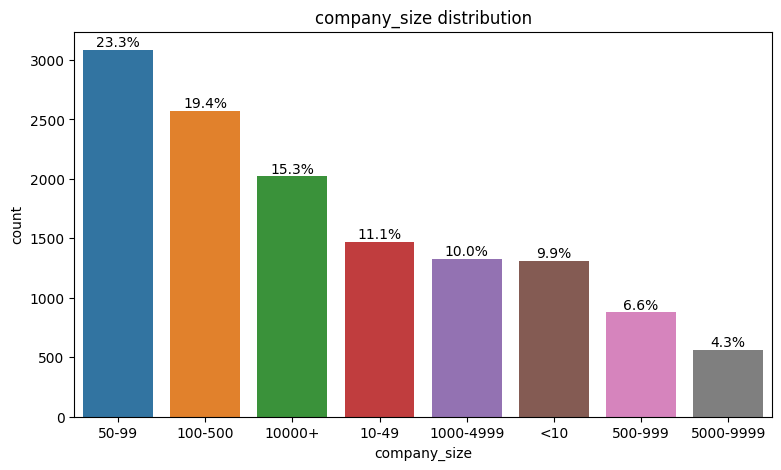

target            0     1    All
company_size                    
10-49          1127   344   1471
100-500        2156   415   2571
1000-4999      1128   200   1328
10000+         1634   385   2019
50-99          2538   545   3083
500-999         725   152    877
5000-9999       461   102    563
<10            1084   224   1308
All           10853  2367  13220


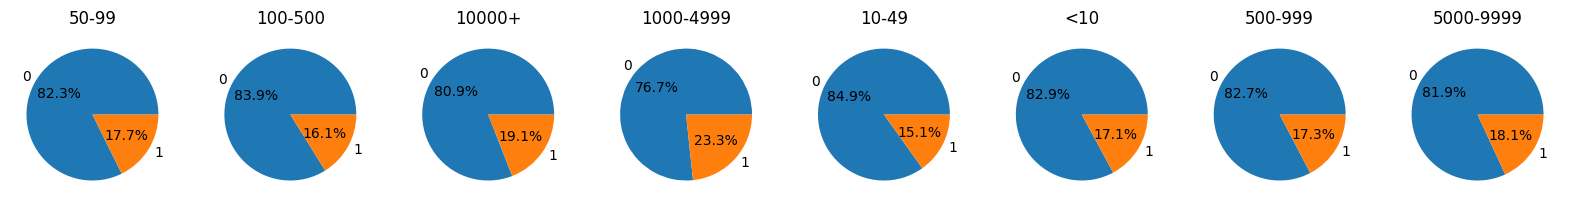

In [27]:
plots('company_size',120)

The distribution of company size values takes a gradual downward trend. Here we can not identify a specific value that is really preponderant: no value clearly imposes itself on the others, but the distribution is more homogeneous. The percentages of target values are quite similar for all cases.

**Company Type**

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64


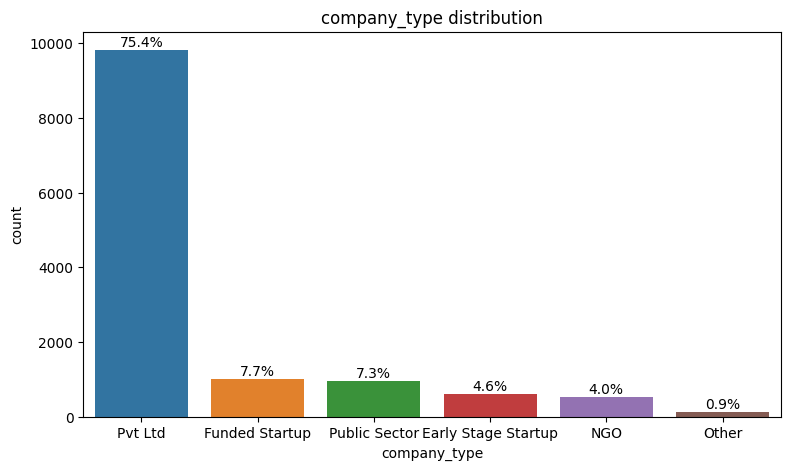

target                   0     1    All
company_type                           
Early Stage Startup    461   142    603
Funded Startup         861   140   1001
NGO                    424    97    521
Other                   92    29    121
Public Sector          745   210    955
Pvt Ltd               8042  1775   9817
All                  10625  2393  13018


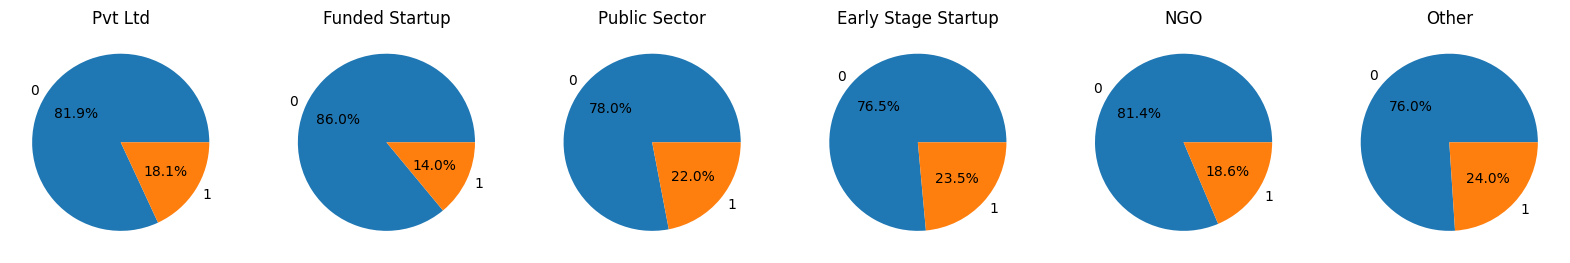

In [28]:
plots('company_type',400)

Around 75% of people are currently working in a private company, the remaining are quite equally distributed among the other options.

**Last New Job**

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64


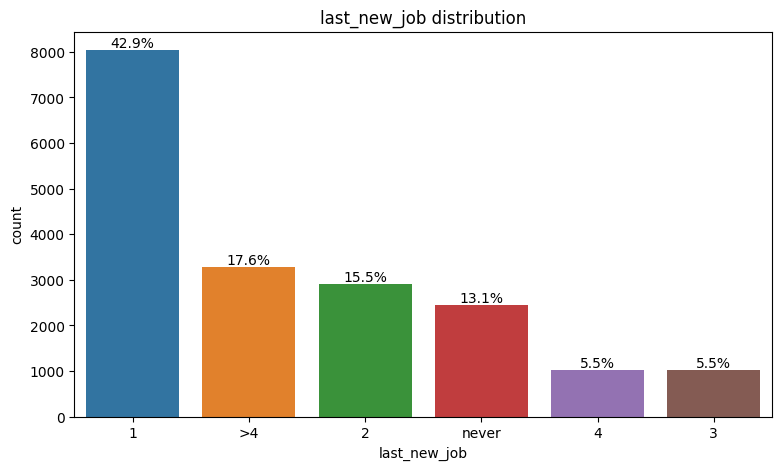

target            0     1    All
last_new_job                    
1              5915  2125   8040
2              2200   700   2900
3               793   231   1024
4               801   228   1029
>4             2690   600   3290
never          1713   739   2452
All           14112  4623  18735


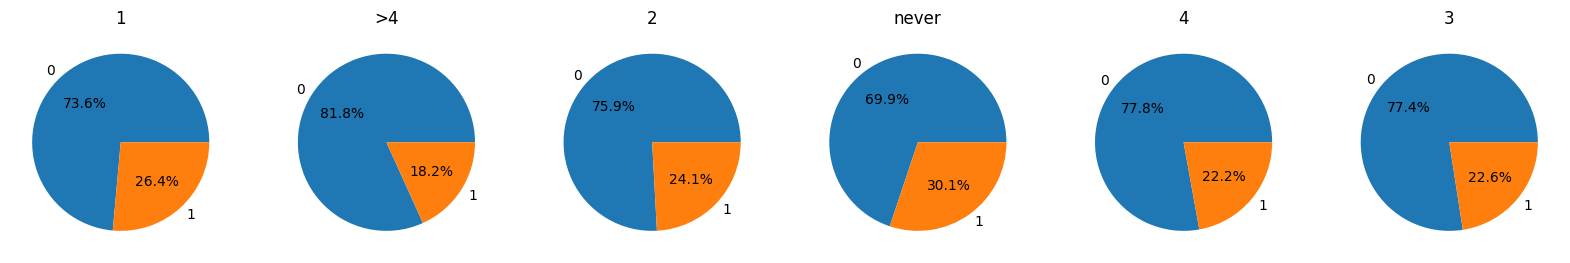

In [29]:
plots('last_new_job',300)

People who are working in the current company for 1 year cover almost half of the samples (43%). From the pie charts it’s interesting to note that as the difference in years between previous and current job increases, the percentage of those who will look for a new job after the training course decreases.

**Target**

0    14381
1     4777
Name: target, dtype: int64


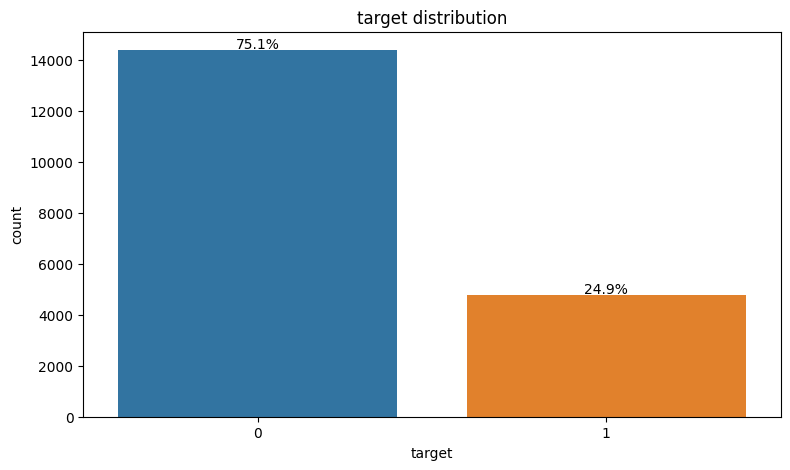

In [30]:
countplot('target',500)

In all the previous pie charts the percentage of records with target value equals to 0 is bigger than the number of records with target value equals to 1. Dataset is clearly unbalanced: around 25% of data belong to class 1 and the remaining 75% belong to class 0. This problem will be solved in the Data Preprocessing section, before the training, in order to have a better prediction.

### Numerical

Now, let’s have a look at numerical features where hist plots are used for the analysis.

In [31]:
def histplot(column):
  plt.figure(figsize=(9,5))
  plt.hist(train[column], bins=20)
  plt.ylabel("Frequency")
  plt.title(column+' distribution')
  plt.show()

**City Development Index**

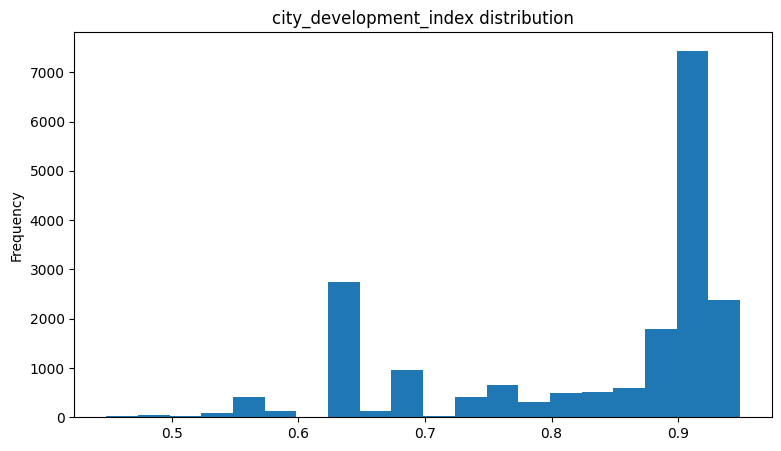

In [32]:
histplot('city_development_index')

Dataset consists of more samples where the city development index is higher than 0.7

**Training hours**

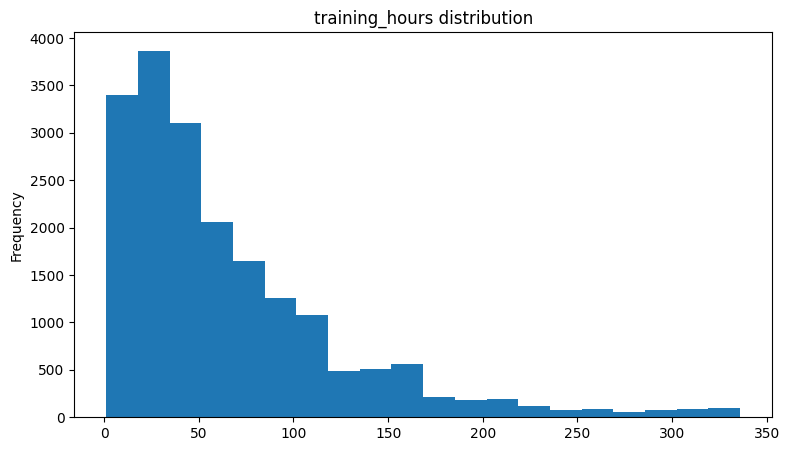

In [33]:
histplot('training_hours')

Dataset consists of more samples where the number of training hours already completed is lower than 150.

## Data Preprocessing

Data preprocessing is the process of cleaning raw data and making it suitable for a machine learning model. It is an integral step since the quality of data and the useful information that can be derived from it directly affects the ability of the model to learn. 



### Feature Removal

As anticipated in the feature distribution section, two features are removed from the dataset since they contain useless or redundant information, becoming irrelevant for our task. These are:

- candidate’s ID

- city code, because the city development index attribute is enough to categorize cities.

In [34]:
train.drop(['enrollee_id','city'],axis=1,inplace=True)

test_id_kaggle=test_kaggle['enrollee_id']
test_kaggle.drop(['enrollee_id','city'],axis=1,inplace=True)

### Duplicate Records

The second step of data cleaning is checking for duplicate records within the dataset.

In [35]:
train.duplicated().any() #NB: I only consider the train dataset because test_kaggle is for kaggle submission (I need all records even if there are duplicates)

True

In [36]:
train.shape

(19158, 12)

In [37]:
train.drop_duplicates(inplace=True)

In [38]:
train.shape

(19098, 12)

In [39]:
train.duplicated().any()

False

60 duplicate records are removed from the dataset. In this way, every single remaining record differs from the others: no one of them is a duplicate anymore.

### Handling Missing Values

Before going into details, dataset is divided into two subsets: 
- **training set**, that consists of 80% of records and it’s used to train the model
- **test set**, that consists of the remaining 20% and it’s used to test the model just trained.

The idea is to apply data preprocessing techniques separately on the training set and test set, and apply data sampling techniques only on the first while keeping the second set unchanged. In this way, the models' performances will be computed over the same samples thus allowing their comparison.

In [40]:
y = train["target"]
X = train.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
      X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)

X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [41]:
train_proc=X_train.copy()
train_proc['target']=y_train

test_proc=X_test.copy()
test_proc['target']=y_test

test_kaggle_proc=test_kaggle.copy()
data_proc = pd.concat([train_proc, test_proc, test_kaggle_proc], ignore_index=True)

Missing value occurs when no data is stored for a variable in a given dataset. The main reasons for having missing values are:


*   Information is not collected
*   Attributes may not be applicable to all cases

In [42]:
def count_missing(ds: pd.DataFrame):
    return ds.shape[0] - ds.count()

In [43]:
def perc_missing(ds: pd.DataFrame):
  return (ds.shape[0] - ds.count())*100/len(ds)

Our dataset contains a lot of NaN: their number and percentage for each attribute is shown below.

In [44]:
df_NaN=pd.DataFrame({'Number of missing values':data_proc.isnull().sum(),'Percentage of missing values':data_proc.isnull().sum()*100/data_proc.shape[0]})
df_NaN

,Number of missing values,Percentage of missing values
city_development_index,0,0.000000
gender,5016,23.630282
relevent_experience,0,0.000000
enrolled_university,417,1.964479
education_level,512,2.412022
major_discipline,3121,14.702973
experience,70,0.329769
company_size,6536,30.790974
company_type,6750,31.799124
last_new_job,463,2.181184


For a better visualization we can use the following plot where variables are ordered by the higher number of NaN.

<Axes: >

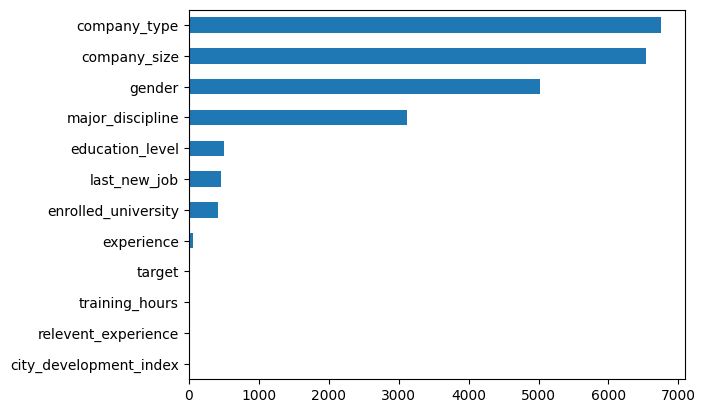

In [45]:
count_missing(data_proc).sort_values().plot.barh()

Let’s now check if there is a relation between attributes, which forces that some values are not applicable thus generating a missing value. After this analysis it was found that:

1) When the education level attribute is equal to “Primary School”, a NaN is expected for the major discipline feature

In [46]:
primary=data_proc[data_proc['education_level'].eq('Primary School')]
print(primary.shape)
primary[primary['major_discipline'].isnull()]

(344, 12)


,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
2,0.899,NaN,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,NaN,never,102,0
67,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,1,NaN,NaN,never,43,0
143,0.920,NaN,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,NaN,never,7,0
144,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,NaN,never,149,0
191,0.836,Male,No relevent experience,no_enrollment,Primary School,NaN,1,NaN,NaN,never,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21110,0.924,Male,No relevent experience,no_enrollment,Primary School,NaN,15,10000+,Pvt Ltd,2,156,0
21123,0.827,Male,No relevent experience,no_enrollment,Primary School,NaN,5,NaN,NaN,never,14,0
21136,0.926,Male,No relevent experience,Part time course,Primary School,NaN,3,NaN,Pvt Ltd,never,100,0
21141,0.767,Other,No relevent experience,no_enrollment,Primary School,NaN,6,NaN,NaN,never,26,0


2) When the education level attribute is equal to “High School”, a NaN is expected for the major discipline feature. 

In [47]:
high=data_proc[data_proc['education_level'].eq('High School')]
print(high.shape)
high[high['major_discipline'].isnull()]

(2235, 12)


,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,0.855,Male,No relevent experience,Full time course,High School,NaN,<1,NaN,NaN,never,6,0
3,0.920,NaN,No relevent experience,no_enrollment,High School,NaN,3,NaN,NaN,NaN,44,0
17,0.910,Male,No relevent experience,no_enrollment,High School,NaN,2,NaN,NaN,never,17,0
19,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,>20,NaN,NaN,>4,102,0
32,0.579,Male,Has relevent experience,no_enrollment,High School,NaN,8,NaN,NaN,1,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21216,0.836,Male,Has relevent experience,no_enrollment,High School,NaN,14,NaN,NaN,1,42,0
21217,0.698,NaN,No relevent experience,Full time course,High School,NaN,8,NaN,NaN,never,55,0
21218,0.926,Male,No relevent experience,no_enrollment,High School,NaN,5,NaN,NaN,never,32,0
21221,0.624,Female,No relevent experience,Full time course,High School,NaN,3,NaN,NaN,never,56,0


A major discipline is the academic discipline to which an undergraduate student formally commits, therefore it’s not applicable to students with a lower education level. For this reason, all these NaN values are replaced by “No major”.

In [48]:
def replaceNaN(df,feature_string):
  for i in df.index:
   if df['education_level'][i]==feature_string:
     df['major_discipline'][i]='No Major'

In [49]:
replaceNaN(train_proc,'Primary School') 
replaceNaN(test_proc,'Primary School') 
replaceNaN(test_kaggle_proc,'Primary School')

<ipython-input-48-03b743a07278>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['major_discipline'][i]='No Major'


In [50]:
replaceNaN(train_proc,'High School') 
replaceNaN(test_proc,'High School') 
replaceNaN(test_kaggle_proc,'High School')

<ipython-input-48-03b743a07278>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['major_discipline'][i]='No Major'


In [51]:
data_proc = pd.concat([train_proc, test_proc, test_kaggle_proc], ignore_index=True)
count_missing(data_proc)

city_development_index       0
gender                    5016
relevent_experience          0
enrolled_university        417
education_level            512
major_discipline           542
experience                  70
company_size              6536
company_type              6750
last_new_job               463
training_hours               0
target                       0
dtype: int64

After this first replacement, the number of missing values for the major discipline feature decreased from 3121 to 542.

Furthermore, I tried to understand when candidates don’t fill in information about the current company just because they don’t work at the moment, but it was not possible to understand how to exactly identify them. Assumptions were reached, but nothing for sure.

Now we can proceed to the **handling of** the remaining **missing values**. Some techniques to do so are:

- eliminate records which contain at least one NaN
- estimate missing values using an imputer
- replace missing values with all possible values weighted by their probabilities.

To understand which technique is best to use, let’s have a look at the distribution of NaN values within the dataset.




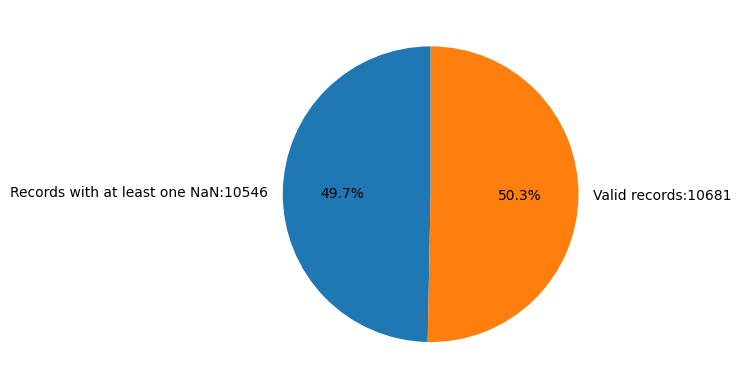

In [52]:
numRecNan=len(data_proc.loc[data_proc.isna().any(axis=1)])
numValid=len(data_proc)-numRecNan
y = np.array([numRecNan, numValid])
mylabels = ["Records with at least one NaN:"+str(numRecNan),"Valid records:"+str(numValid)]

plt.pie(y, labels = mylabels, startangle = 90, autopct='%1.1f%%')
plt.show() 

Since 50% of records in the dataset have at least one NaN, eliminating them is not a good strategy. Instead, estimating them through an imputer or replacing them using probability distributions are better. 



Before applying one of these techniques, two main cases can be identified:
1. features with a high number of missing values but in a limited way compared to the amount of data
2. features with a small number of missing values




In [53]:
def barNaN(features,nullValues,color,more_less):
  y_pos = np.arange(len(features)) 
  f=plt.subplots(figsize=(15,5))
  plt.grid(zorder=0)
  plt.bar(y_pos, nullValues, align='center', alpha=0.5, color=color, zorder=3)
  plt.xticks(y_pos, features)
  plt.ylabel('NULL Values')
  plt.xlabel('Features')
  plt.title('Features with '+more_less+' than 1000 NULL values')
  plt.show()

In [54]:
def pieNaN(features):
  fig, axs = plt.subplots(1,len(features)) 
  fig.set_size_inches(20, 10)
  mylabels = ["NaN", "Valid Values"] 

  i=0
  for column in features:
    perc=perc_missing(data_proc[column])
    y = np.array([perc, 100-perc])
    axs[i].pie(y, labels = mylabels,autopct='%1.1f%%')
    axs[i].set_title(column)
    i=i+1
  plt.show()

In [55]:
def plotsNaN(features,nullValues,color,more_less):
  barNaN(features,nullValues,color,more_less)
  pieNaN(features)

***CASE 1) High number of missing values***

In [56]:
features_more1000 = []
nullValues_more1000 = []

for i in data_proc:
    if count_missing(data_proc[i])>1000 and i!='target':
        features_more1000.append(i)
        nullValues_more1000.append(count_missing(data_proc[i]))

features_more1000

['gender', 'company_size', 'company_type']

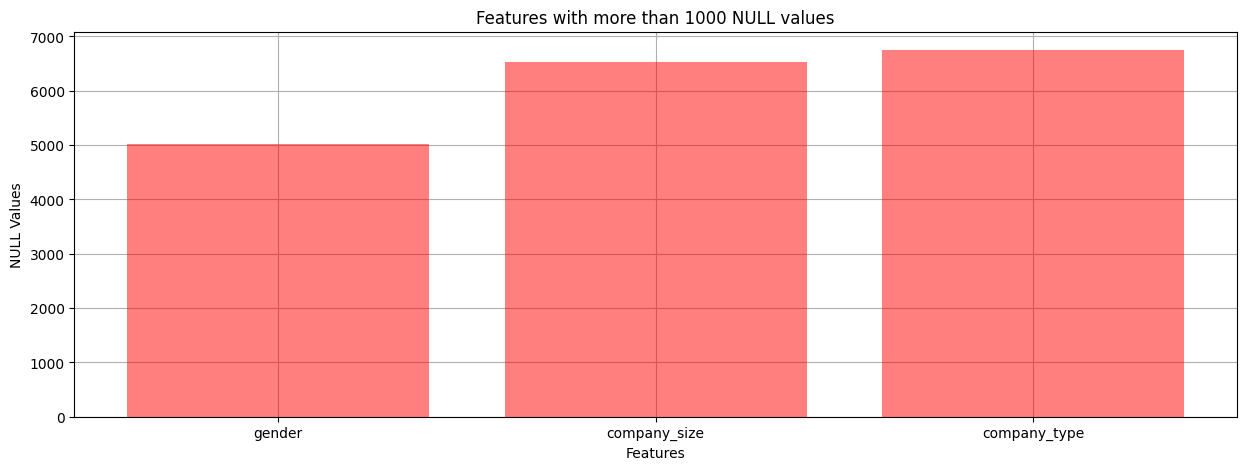

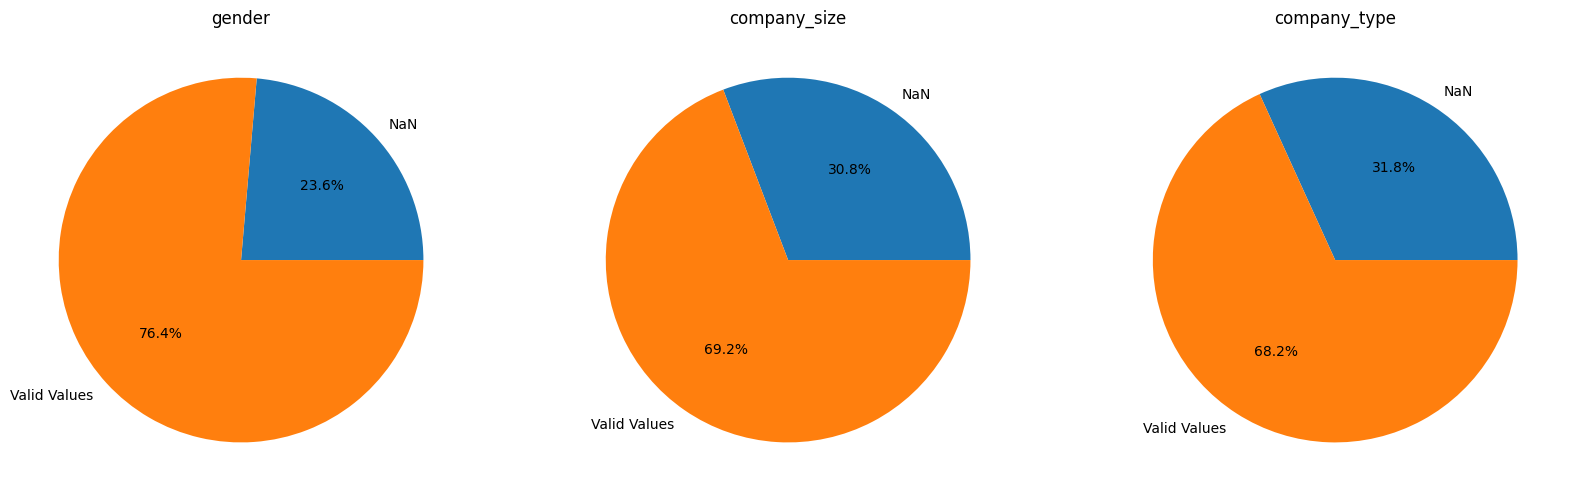

In [57]:
plotsNaN(features_more1000,nullValues_more1000,"red","more")

Regarding the **gender** attribute
- 90.2% of the samples are Male
- 8.5% are female 
- 1.3% belong to another category.

Therefore, replacing all the 5016 NaN with the most frequent value through the imputer or replacing them with all the possible values weighted by their probabilities is quite similar.

Regarding the **company type** attribute
- 75% of the candidates currently work in a private company
- the remaining are distributed among the other 5 options. 

Therefore, in this case choosing between the two techniques is quite different, since the number of missing values is very high. 

Regarding the **company size** attribute records are more equally distributed among the several options. Thus, replacing all the 6536 NaN with the most frequent value or replacing them with all possible values is very different. The first case can lead to a heavy imbalance of its feature distribution.


After all these considerations, I decided to replace these NaN with all the possible values weighted by their probabilities. To do so, a function that fills missing values though an **extraction with reinsertion based on the probability distribution** of the several values was defined.

In [58]:
def fill_feature(column_feature):

 value_counts= column_feature.value_counts()
 probabilities= value_counts/column_feature.count()
 feature_unique=value_counts.index[:]

 for i in range(len(column_feature)):
   if pd.isna(column_feature[i]):
    column_feature[i] = np.random.choice(feature_unique, size=None, replace=True, p=probabilities)

 return column_feature

In [ ]:
for i in features_more1000:
  train_proc[i]=fill_feature(train_proc[i])
  test_proc[i]=fill_feature(test_proc[i])
  test_kaggle_proc[i]=fill_feature(test_kaggle_proc[i])

***CASE 2) Small number of missing values***

In [60]:
features_less1000 = []
nullValues_less1000 = []

for i in data_proc:
    count_NaN=count_missing(data_proc[i])
    if  count_NaN<=1000 and count_NaN>0 and i!='target':
        features_less1000.append(i)
        nullValues_less1000.append(data_proc.isna().sum()[i])

features_less1000

['enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'last_new_job']

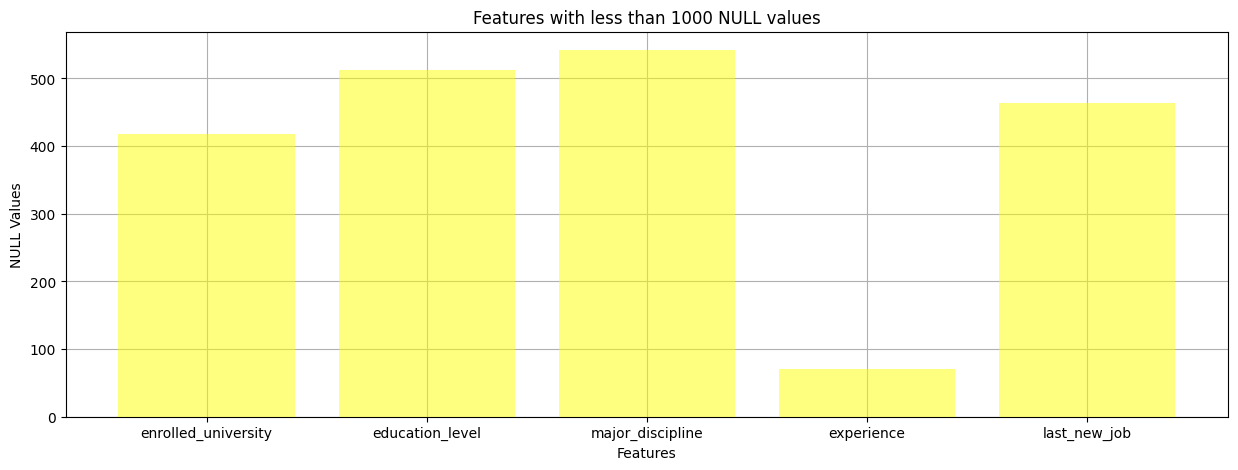

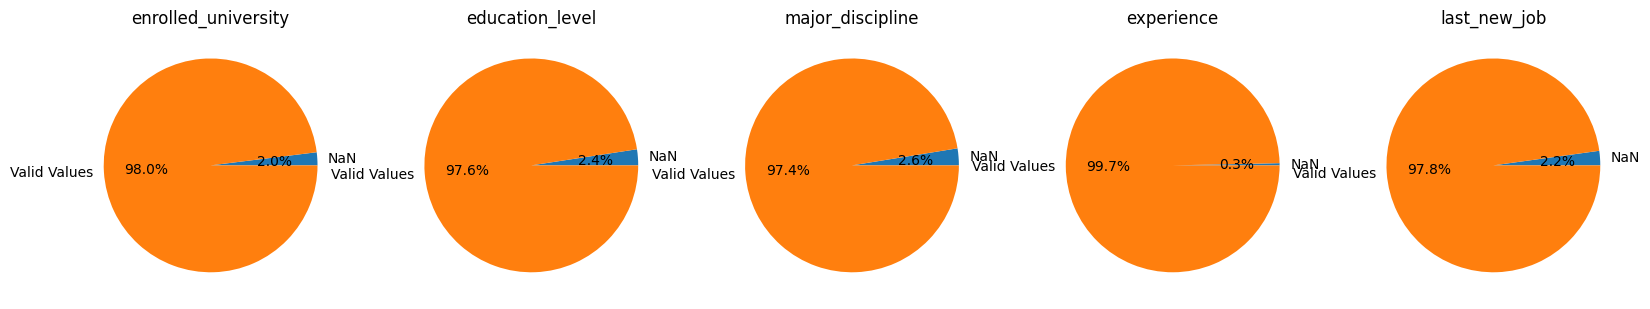

In [61]:
plotsNaN(features_less1000,nullValues_less1000,"yellow","less")

In this case the number of missing values is very small compared to the entire amount of data. Therefore, we can skip the consideration made before and directly apply the **imputer**, replacing the nulls with the most frequent value in each column.

In [62]:
train_proc[features_less1000]=SimpleImputer(strategy="most_frequent").fit_transform(train_proc[features_less1000])
test_proc[features_less1000]=SimpleImputer(strategy="most_frequent").fit_transform(test_proc[features_less1000])
test_kaggle_proc[features_less1000]=SimpleImputer(strategy="most_frequent").fit_transform(test_kaggle_proc[features_less1000])

In [63]:
data_proc = pd.concat([train_proc, test_proc, test_kaggle_proc], ignore_index=True)

Once the necessary treatments have been applied, let’s recalculate that the number of missing values for each feature is equal to 0, in order to verify they are no longer present in the dataset.

In [64]:
df_NaN = pd.DataFrame({'Number of missing values':data_proc.isnull().sum(),'Percentage of missing values':data_proc.isnull().sum()*100/data_proc.shape[0]})
df_NaN

,Number of missing values,Percentage of missing values
city_development_index,0,0.0
gender,0,0.0
relevent_experience,0,0.0
enrolled_university,0,0.0
education_level,0,0.0
major_discipline,0,0.0
experience,0,0.0
company_size,0,0.0
company_type,0,0.0
last_new_job,0,0.0


### Feature scaling


In the feature distribution section we saw that the city development index ranges from 0.448 to 0.949, whereas training hours is from 1 to 336. The machine learning algorithm thinks that the feature with higher range values is most important while predicting the output and tends to ignore the feature with small range values. To avoid it, the range of all features are scaled so that each feature contributes proportionately and model performance improves. Therefore, a **StandardScaler** is applied to these numerical attributes.

In [65]:
from sklearn.preprocessing import StandardScaler

numcols = ['city_development_index', 'training_hours']
scaler = StandardScaler().fit(data_proc[numcols])

train_proc[numcols] = scaler.transform(train_proc[numcols])
test_proc[numcols] = scaler.transform(test_proc[numcols])
test_kaggle_proc[numcols] = scaler.transform(test_kaggle_proc[numcols])

Rescaling the distribution does not affect the shape.

### Data Sampling

In [66]:
y_train = train_proc["target"]
X_train = train_proc.drop("target", axis=1)

y_test = test_proc["target"]
X_test = test_proc.drop("target", axis=1)

As already anticipated during the feature distribution analysis,the dataset is unbalanced:

- 75% records with target value of 0
- 25% records with target value of 1

Therefore, class 0 is called **majority class** and class 1 is called the **minority class**.

0    11478
1     3800
Name: target, dtype: int64


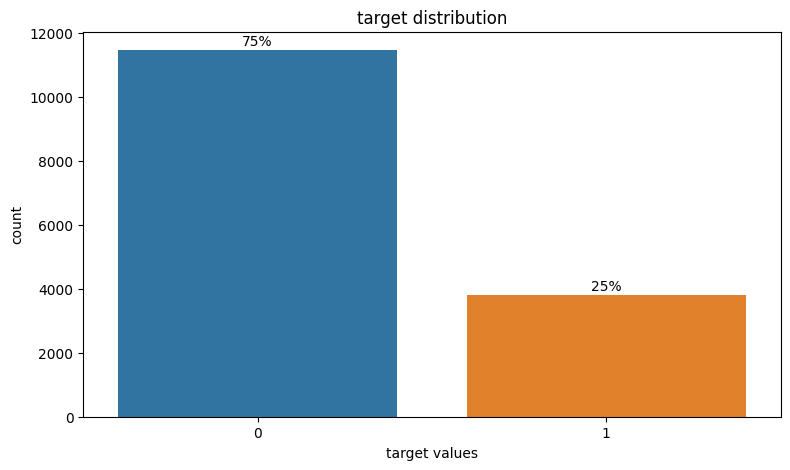

In [67]:
count = y_train.value_counts()
print( count )
plt.figure(figsize = (9,5))
sns.countplot(x=y_train);
plt.title('target distribution');
plt.xlabel('target values');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] /y_train.count()))+'%',
            ha='center',
            va = 'top')

The main problem with an imbalanced dataset is that classes are not represented equally and the classifier may get biased towards prediction: it could not be accurate enough to predict both the majority and minority class. The model should not be biased to detect only the majority class but should give equal weight or importance towards the minority too. 

Among the techniques which can deal with this problem are the **oversampling** and **undersampling**. In general, undersampling can be implemented when the dataset is sufficient, however, in most cases oversampling is preferred as the first can undergo loss of important data. Since the two methods are compatible with our dataset, I decided to implement both, to understand which one leads to best results.




#### Oversampling



This technique increases the minority class adding new minority elements to the dataset. There are two ways to implement it:
- **RandomOverSampler**, that generates new samples by randomly sampling with replacement the current available instances;
- **SMOTE** (Synthetic Minority Oversampling Technique), that creates new synthetic samples based on the original instances, increasing both the size of the training set and the variety of examples.

I decided to use the first approach since it lead to better performances. 


In [68]:
#ros = RandomOverSampler(random_state=42)
#X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5,6,7,8,9])
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)



0    11478
1    11478
Name: target, dtype: int64


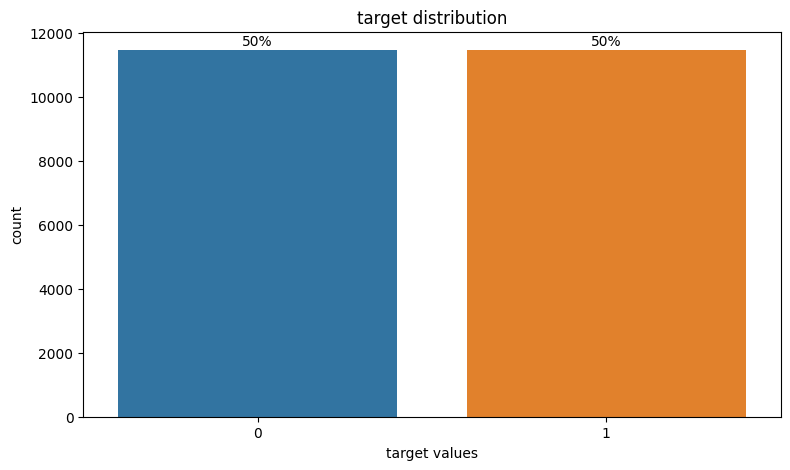

In [69]:
count = y_train_over.value_counts()
print( count )
plt.figure(figsize = (9,5))
sns.countplot(x=y_train_over);
plt.title('target distribution');
plt.xlabel('target values');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 500,
            str(round(100*count[i] /y_train_over.count()))+'%',
            ha='center',
            va = 'top')

Thanks to the oversampling, the number of records with target value equal to 1 has increased from 4800 to 11478, now balancing the number of samples with the other value.

#### Undersampling

Instead of increasing the minority class, this method reduces the majority one removing some instances from this group. Among the several approches available in imblearn.under_sampling, I implemented the **RandomUnderSampler**. It provides a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes.

In [70]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

0    3800
1    3800
Name: target, dtype: int64


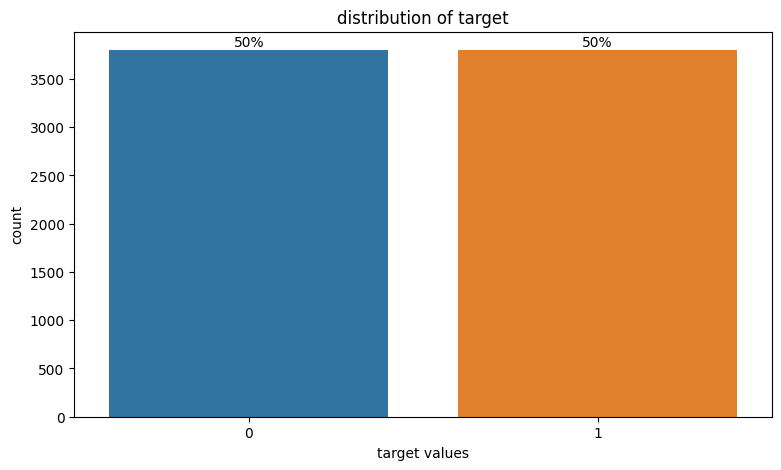

In [71]:
count = y_train_under.value_counts()
print( count )
plt.figure(figsize = (9,5))
sns.countplot(x=y_train_under);
plt.title('distribution of target');
plt.xlabel('target values');
plt.ylabel('count');
for i in range(count.shape[0]):
    plt.text( 
            i,
            count[i] + 150,
            str(round(100*count[i] /y_train_under.count()))+'%',
            ha='center',
            va = 'top')

Thanks to the undersampling, the number of records with target value equal to 0 has decreased from 11478 to 3800, now balancing the number of samples with the other value.

In [72]:
X_train_under


,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.766469,Female,No relevent experience,Full time course,Graduate,STEM,4,10000+,Pvt Ltd,1,2.338499
1,-1.652959,Male,No relevent experience,Full time course,Graduate,STEM,2,1000-4999,Pvt Ltd,never,-0.239637
2,0.661277,Male,Has relevent experience,no_enrollment,High School,No Major,>20,10000+,Pvt Ltd,>4,-0.938229
3,-1.054171,Male,Has relevent experience,Full time course,Graduate,STEM,4,<10,Funded Startup,1,-0.322803
4,0.742194,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,-0.988129
...,...,...,...,...,...,...,...,...,...,...,...
7595,-1.183639,Female,Has relevent experience,Full time course,Graduate,STEM,3,<10,Pvt Ltd,never,-0.871697
7596,0.216231,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,1,-0.439235
7597,0.742194,Male,No relevent experience,no_enrollment,Graduate,Humanities,10,1000-4999,Pvt Ltd,2,0.026493
7598,-2.017087,Male,Has relevent experience,Full time course,High School,No Major,3,10-49,Pvt Ltd,1,2.970559


### Feature encoding

Most machine learning models can only work with numerical values. For this reason, it is necessary to transform the categoricals into numericals. **Label encoding** is one of the most basic types of categorical feature encoding methods since it simply assigns a number to each unique value in a feature. This technique was applied differently depending on the type of categorical feature. 

#### Ordinal Categorial Features

Ordinal features are categorical features characterized by a clear ordering. To maintain this relationship, the function ‘encode_ord_categorical’ was set up to assign a specifi number to each values in a feature, using a dictionary mapping.

In [73]:
d={'<1': 0}
d.update({f'{i}':i for i in range(1,21)})
d.update({'>20':21})

def encode_ord_categorical(df):
  df['relevent_experience']=df['relevent_experience'].map({'Has relevent experience': 1, 'No relevent experience': 0})
  df['enrolled_university']=df['enrolled_university'].map({'no_enrollment': 0, 'Full time course': 2, 'Part time course': 1})
  df['education_level']=df['education_level'].map({'Primary School': 0, 'High School': 1, 'Graduate': 2, 'Masters': 3, 'Phd': 4})
  df['experience']=df['experience'].map(d)
  df['company_size']=df['company_size'].map({'<10': 0, '10-49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7})
  df['last_new_job']=df['last_new_job'].map({'never': 0, '1': 1, '2': 2, '3': 3, '4': 4,'>4': 5})


In [74]:
X_train_over_enc=X_train_over.copy()
X_train_under_enc=X_train_under.copy()
X_train_enc=X_train.copy()
X_test_enc=X_test.copy()

test_kaggle_enc=test_kaggle_proc.copy()

In [75]:
encode_ord_categorical(X_train_over_enc)
encode_ord_categorical(X_train_under_enc)
encode_ord_categorical(X_train_enc)
encode_ord_categorical(X_test_enc)

encode_ord_categorical(test_kaggle_enc)

#### Nominal Categorial Features

Nominal variables are categorical features without an intrinsic ordering to its categories. Therefore, the numbers assigned for the options are random and their labels have no actual meaning. They are simple to deal with. To do so, the function ‘encode_nom_categorial’ was set up using the LabelEncoder from sklearn.preprocessing.

In [76]:
def encode_nom_categorical(df):
  nominal_categorial = [feature for feature in df.columns if df.dtypes[feature] == 'object']

  for feature in nominal_categorial:
    le = LabelEncoder()
    le.fit(df[feature])
    df[feature]=le.transform(df[feature])
    feature_labels = dict(zip(le.classes_, le.transform(le.classes_)))
    print(feature_labels)

In [77]:
encode_nom_categorical(X_train_over_enc)
encode_nom_categorical(X_train_under_enc)
encode_nom_categorical(X_train_enc)
encode_nom_categorical(X_test_enc)

encode_nom_categorical(test_kaggle_enc)

{'Female': 0, 'Male': 1, 'Other': 2}
{'Arts': 0, 'Business Degree': 1, 'Humanities': 2, 'No Major': 3, 'Other': 4, 'STEM': 5}
{'Early Stage Startup': 0, 'Funded Startup': 1, 'NGO': 2, 'Other': 3, 'Public Sector': 4, 'Pvt Ltd': 5}
{'Female': 0, 'Male': 1, 'Other': 2}
{'Arts': 0, 'Business Degree': 1, 'Humanities': 2, 'No Major': 3, 'Other': 4, 'STEM': 5}
{'Early Stage Startup': 0, 'Funded Startup': 1, 'NGO': 2, 'Other': 3, 'Public Sector': 4, 'Pvt Ltd': 5}
{'Female': 0, 'Male': 1, 'Other': 2}
{'Arts': 0, 'Business Degree': 1, 'Humanities': 2, 'No Major': 3, 'Other': 4, 'STEM': 5}
{'Early Stage Startup': 0, 'Funded Startup': 1, 'NGO': 2, 'Other': 3, 'Public Sector': 4, 'Pvt Ltd': 5}
{'Female': 0, 'Male': 1, 'Other': 2}
{'Arts': 0, 'Business Degree': 1, 'Humanities': 2, 'No Major': 3, 'Other': 4, 'STEM': 5}
{'Early Stage Startup': 0, 'Funded Startup': 1, 'NGO': 2, 'Other': 3, 'Public Sector': 4, 'Pvt Ltd': 5}
{'Female': 0, 'Male': 1, 'Other': 2}
{'Arts': 0, 'Business Degree': 1, 'Humaniti

### Feature correlation

Feature correlation is a measure of the **dependence degree between two random variables**. It can be positive if the increase of one variable is related to the increase of another one, or negative if the increase of one variable is related to the decrease of the other one. 

In this section the idea is to analyze the feature correlation both before and after the application of all data preprocessing techniques, to verify that correlations remain almost the same. In particular we want to check that the handling of missing values and data sampling have not generated correlations too strong or weak.

These values can be interpreted as follows:
- between 0.9 and 1 -> variables are very strongly or perfectly correlated;
- between 0.7 and 0.9 -> variables are strongly correlated;
- between 0.5 and 0.7 -> variables are moderately correlated;
- between 0.3 and 0.5 -> variables are weakly correlated;
- between 0 and 0.3 -> variables are very weakly correlated or without correlation.

NB: If the coefficient is bigger than 0.7, the two features are strongly dependent and one of them should be removed from the dataset because it is redundant.


In [78]:
def heatCorr(df):
  plt.subplots(figsize=(20,15))
  sns.heatmap(df.corr(), annot_kws={"size": 10} ,annot=True, cmap=plt.cm.Reds)

#### Initial Correlation

To analyze the feature correlation before the application of data preprocessing techniques, all records of the original dataset containing missing values are removed using the dropna() function, and after that, categorical features are encoded.

In [79]:
train_no_nans=train.copy()
train_no_nans = train_no_nans.dropna()

In [80]:
encode_ord_categorical(train_no_nans)
encode_nom_categorical(train_no_nans)

{'Female': 0, 'Male': 1, 'Other': 2}
{'Arts': 0, 'Business Degree': 1, 'Humanities': 2, 'No Major': 3, 'Other': 4, 'STEM': 5}
{'Early Stage Startup': 0, 'Funded Startup': 1, 'NGO': 2, 'Other': 3, 'Public Sector': 4, 'Pvt Ltd': 5}


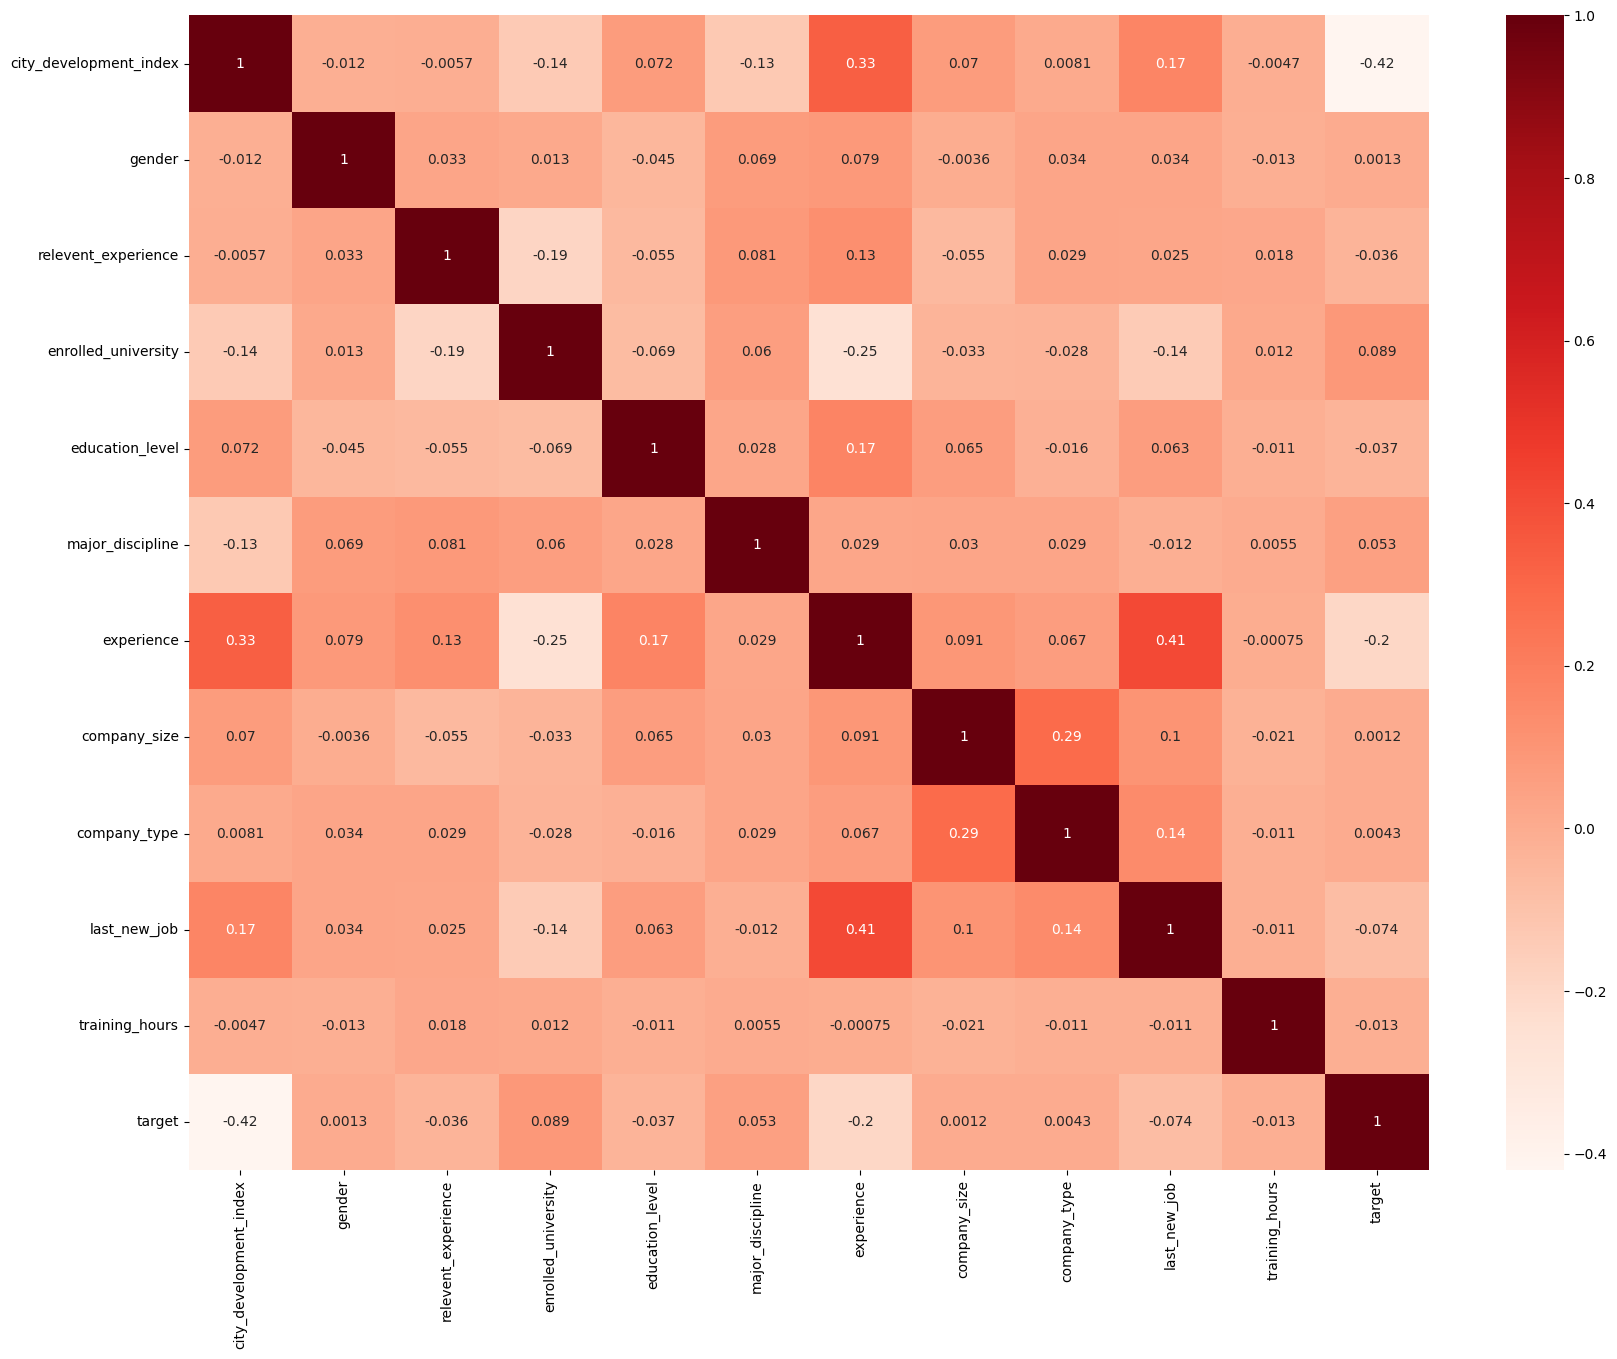

In [81]:
heatCorr(train_no_nans)

The initial correlation matrix shows that:
- Correlations between target class and the other features are very weak, except for the couple (city_development_index, target) where the coefficient is equal to -0.42 that indicates a weak/moderate correlation. The negative value means that if the city development index increases the target value tends to decrease and viceversa;
- Almost all correlations between input attributes are very weak, except for the couples (city_development_index, experience) and (last_new_job, experience) where the coefficients are respectively equal to 0.33 and 0.42;
- There is no couple with a coefficient bigger than 0.7 meaning a strong correlation.



#### Correlation after data preprocessing

*CASE 1) Oversampling*

In [82]:
train_over_enc=X_train_over_enc.copy()
train_over_enc['target']=y_train_over


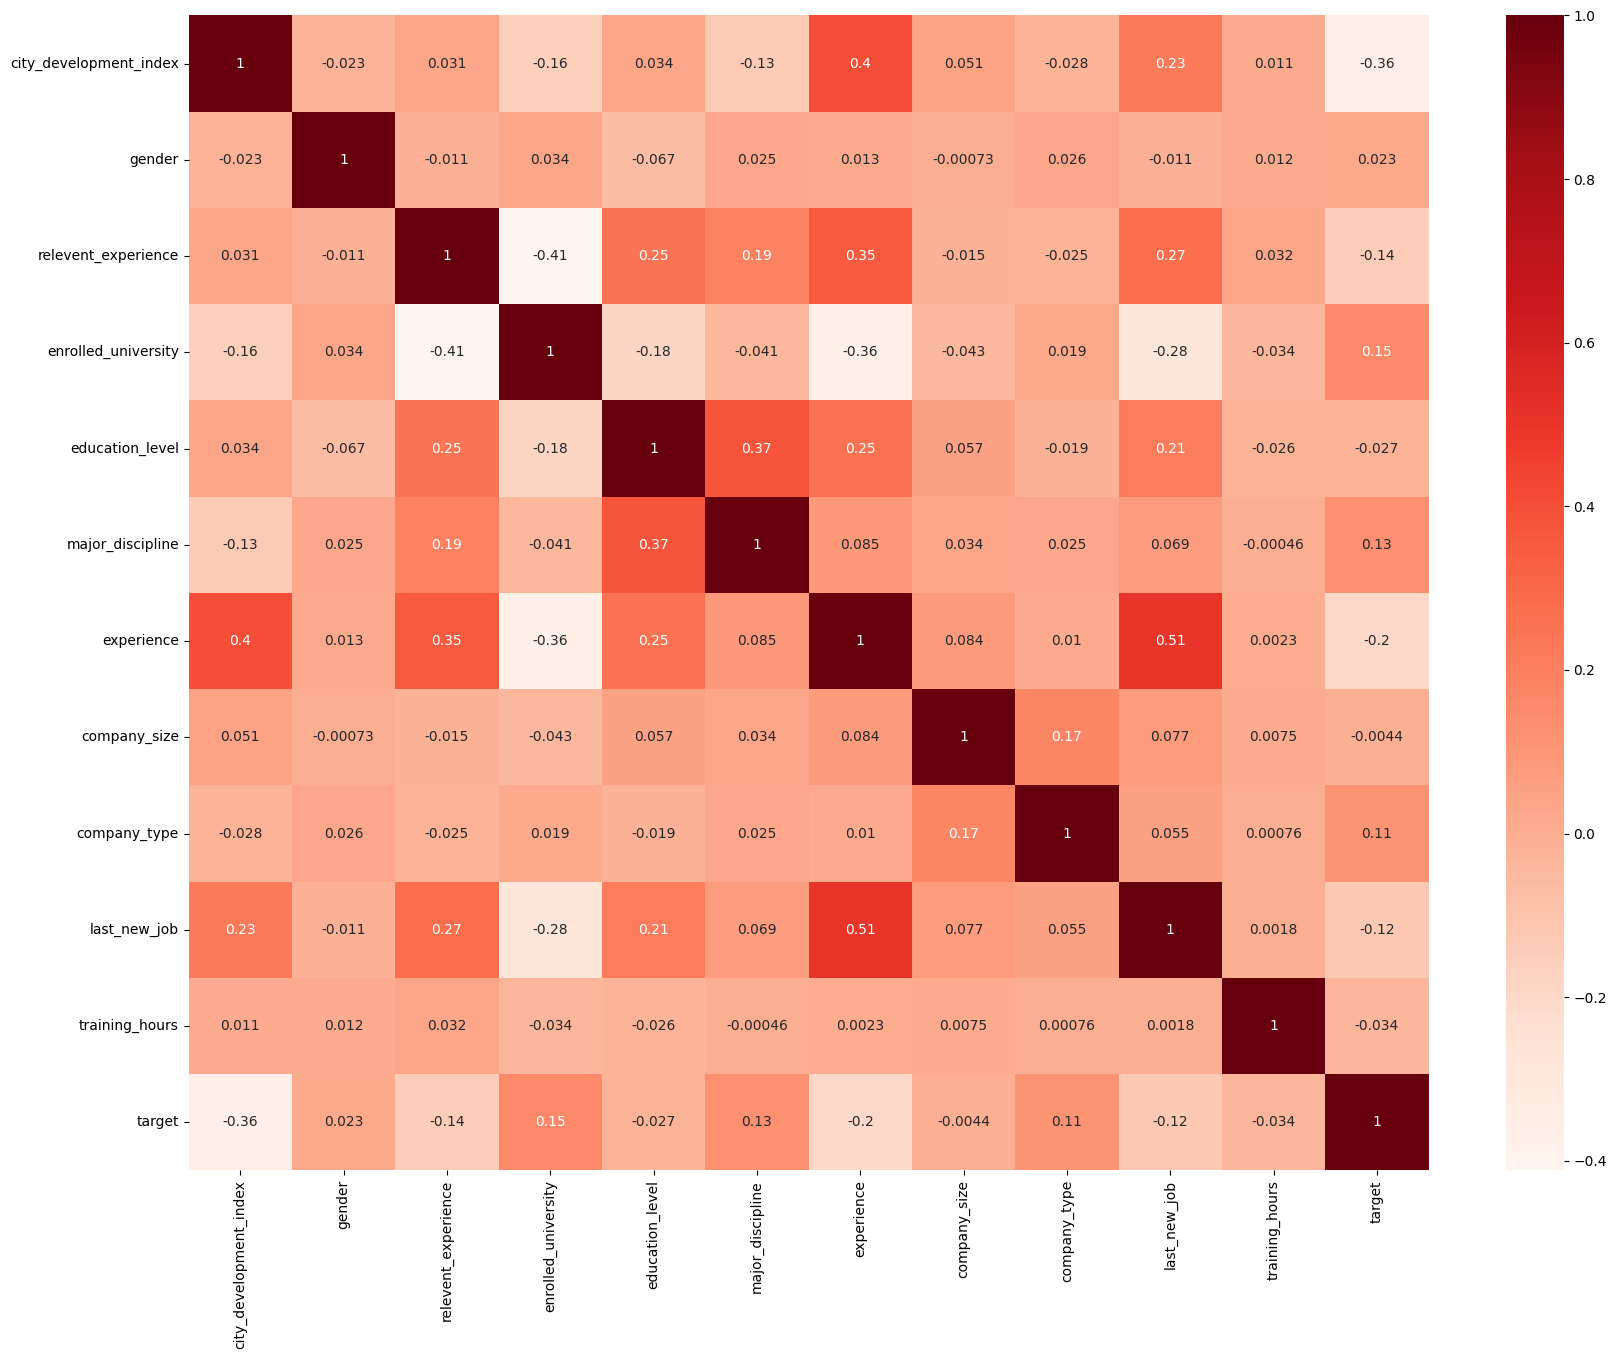

In [83]:
heatCorr(train_over_enc)

The correlation matrix after the handling of missing values and the oversampling shows that:
- Correlations between target class and the other features are very weak, except for the couple (city_development_index , target) where the coefficient is equal to -0.36 that indicates a weak correlation;
- Almost all correlations between input attributes are very weak, but in this case there are six couples with a coefficient between 0.3 and 0.5. Among them the highest value is 0.5 associated to the couple (last_new_job, experience) that indicates a weak/moderate correlation;

- There is no couple with a coefficient bigger than 0.7.


*CASE 2) Undersampling*

In [84]:
train_under_enc=X_train_under_enc.copy()
train_under_enc['target']=y_train_under

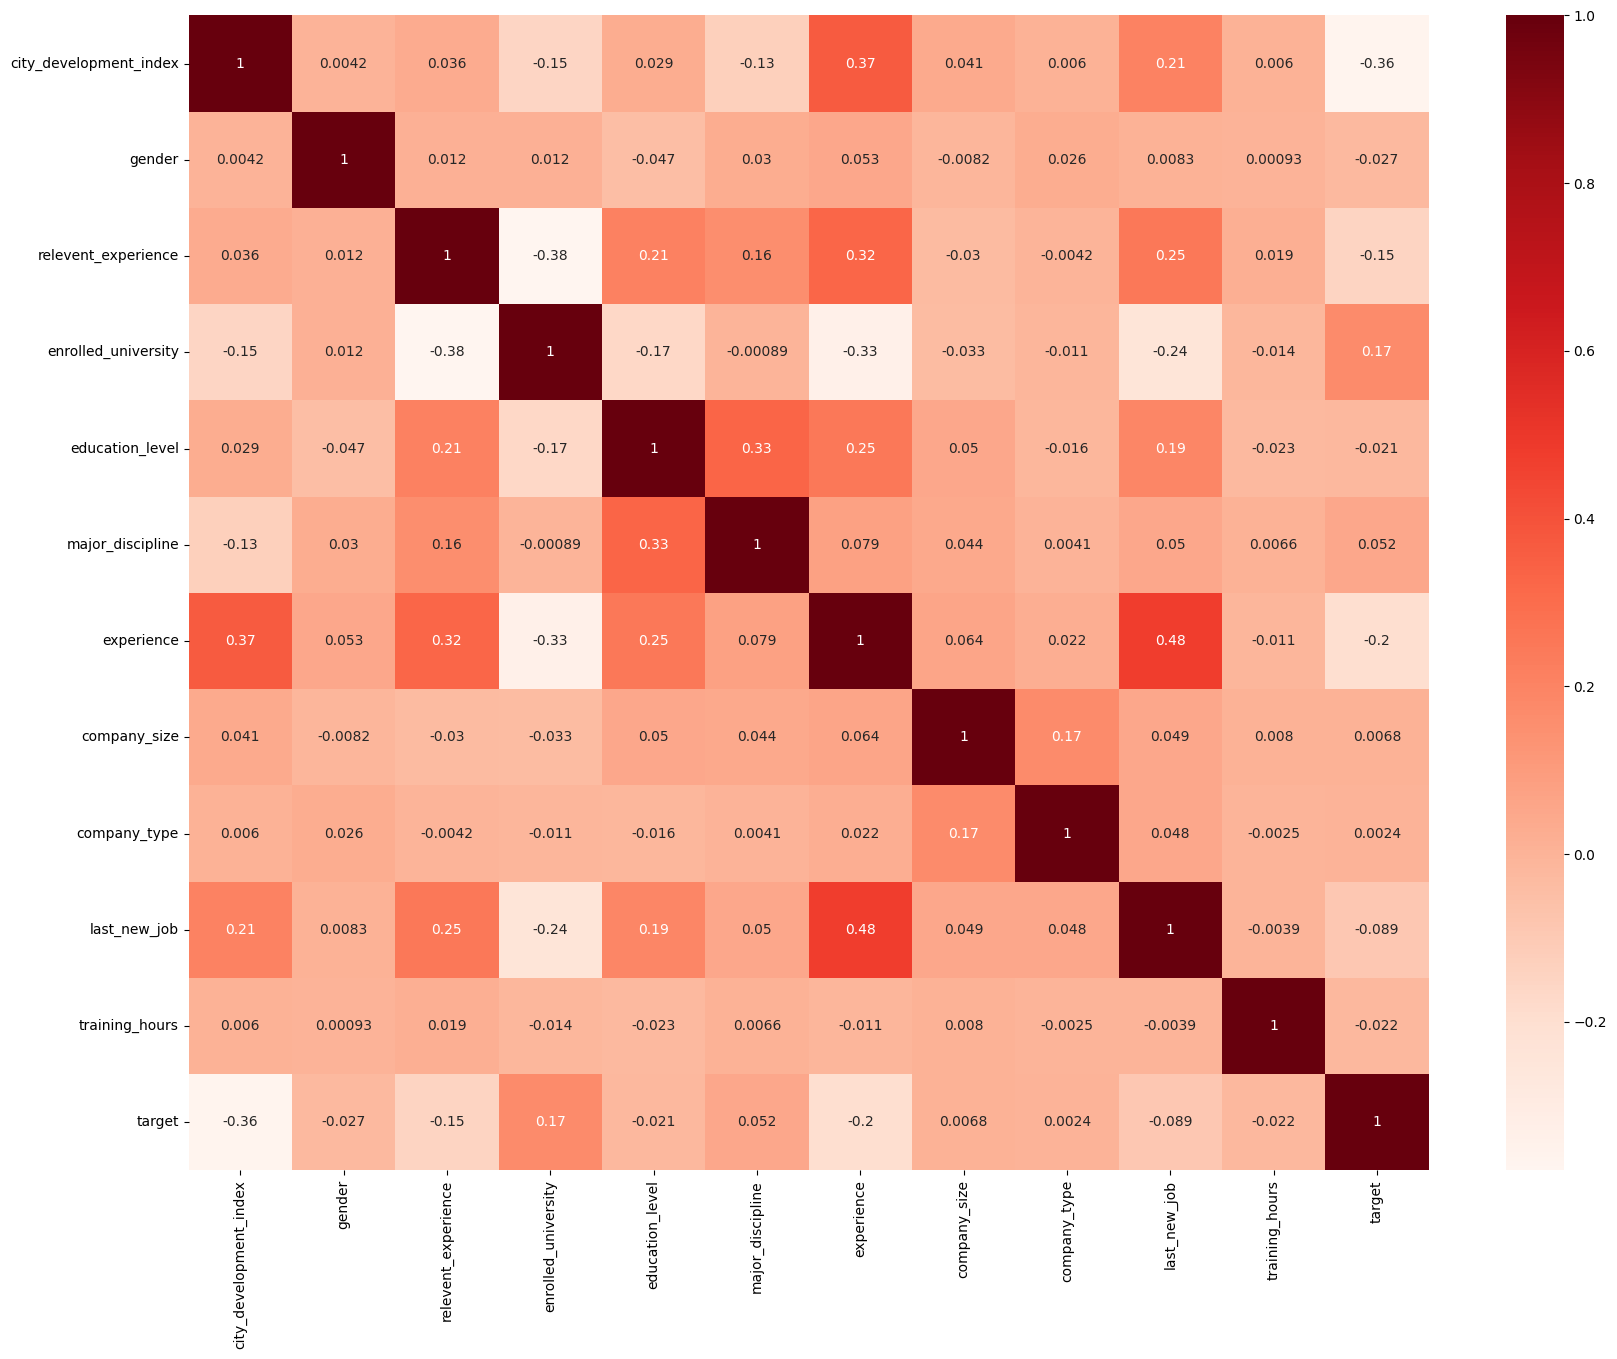

In [85]:
heatCorr(train_under_enc)


The correlation matrix after the handling of missing values and the undersampling shows that:
- Correlations between target class and the other features are very weak, except for the couple (city_development_index, target) where the coefficient is equal to -0.36 that indicates a weak correlation;
- Almost all correlations between input attributes are very weak, but in this case there are six couples with a coefficient between 0.3 and 0.5. Among them the highest value is 0.48 associated to the couple (last_new_job, experience)that indicates a weak/moderate correlation;

- There is no couple with a coefficient bigger than 0.7.


In conclusion, after the handling of missing values and the implementation of a data sampling technique, the correlation coefficients between some features became slightly heavier. However, no correlation with a magnitude higher than 0.7 was introduced, thus, no significant difference can be identified between the before and after cases. Most features remain weakly or very weakly correlated.

# Training



In machine learning, training is a process in which a machine learning algorithm is fed by training data to learn how to make predictions for a given task. In particular, in this work we want a model that can predict whether a candidate really wants to work for the company after the training courses or will look for a new job. 

Data available will be used to train and test several machine learning models, each characterized by a set of parameters that can be tuned to optimize the classification. The traditional way of performing **parameter tuning** is the Grid Search that basically explores a range of parameters and finds the best combination. During this process the cross validation technique is used to prevent the overfitting. It makes use of stratified folds to ensure that splits will not be completely random but the ratio between target classes will be the same in each fold as it is in the full dataset.

In [86]:
def gridSearchFunction(classifier,parameters,X_train,y_train):

  # Create the parameter grids
  parameter_grid = parameters

  # Create Stratified folds
  cross_validation = StratifiedKFold(n_splits=10)
  cross_validation.get_n_splits(X_train, y_train)

  # Create the scoring dictionary
  SCORING = {
      "accuracy": "accuracy",
      "balanced_accuracy": "balanced_accuracy",
      "f1": "f1_macro",
  }

  # Create and fit the GridSearchCV
  grid_search = GridSearchCV(
      estimator=classifier,
      param_grid=parameter_grid,
      cv=cross_validation,
      verbose=1,
      scoring=SCORING,
      return_train_score=True,
      refit="accuracy",
      n_jobs=-1
  )

  grid_search.fit(X_train, y_train)
  
  #grid_search.cv_results_
  print("Best score: {}".format(grid_search.best_score_))
  print("Best parameters: {}".format(grid_search.best_params_))

  return grid_search.best_estimator_


Each model will be evaluated on a complete set of metrics:
- ***Accuracy = (TP+TN)/N*** 
- ***Recall = TP/(TP+FN)***
- ***Specificity = TN/(TN+FP)***
- ***Precision = TP/(TP+FP)***
- ***F1 Score = 2TP/(2TP+FN+FP)***
- ***AUC Score = area under ROC curve***

where TP is the number of true positives, TN of true negatives, FP of false positives and FN of false negatives. These values are obtained by confusion matrices.

Although widely used, accuracy can be inappropriate for imbalanced classification because a high value is achievable by a model that predicts well only the majority class. Also ROC Curve and ROC AUC are generally effective, but can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small. Instead, other metrics such as recall, specificity and precision may be more useful as they focus on one class.

In [87]:
def fit_predict(model,X_train,y_train,X_test,y_test):
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy=accuracy_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  cm=confusion_matrix(y_test,y_pred)
  specificity=cm[0,0]/(cm[0,1]+cm[0,0])
  precision=precision_score(y_test, y_pred)
  F1_score=f1_score(y_test,y_pred)
  y_probs = model.predict_proba(X_test)
  AUC_score=roc_auc_score(y_test,y_probs[:,1])#area under ROC curve

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("-------------------------")
  print("Confusion Matrix")
  f = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
  plt.show()
  plt.close()

  print("-------------------------")
  print("ROC")
  fpr, tpr, _ = roc_curve(y_test, y_probs[:,1], pos_label=model.classes_[1])
  RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
  plt.show()
  plt.close()
  

  return accuracy,recall,specificity,precision,F1_score,AUC_score

In [88]:
COLUMN_NAMES= [feature for feature in test_kaggle_enc.columns if feature != 'target']

def featureImp(model):
  feature_importances = pd.DataFrame(
    model.feature_importances_, index=COLUMN_NAMES, columns=["importance"]
  ).sort_values("importance", ascending=False)
  return feature_importances
  #plt.figure(figsize = (7,5))
  #sns.barplot(x = 'importance', y = COLUMN_NAMES , data = feature_importances)

## Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 

After reading the documentation provided by Sklearn, the set of parameters chosen for the parameter tuning process is:
- **criterion**, that is the function used to measure the quality of a split;
- **splitter**, that is the strategy used to choose the split at each node;
- **max_depth**, that is the maximum depth of the tree;
- **max_features**, that is the number of features to consider when looking for the best split.

Instead, the others are set by default.


In [307]:
dtc=DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_parameters= {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [4, 5, 6, 7, 8, 9, 10],
    "max_features": [6, 8, 10,"sqrt", "log2", None]
}

### Oversampling

In [308]:
dtc_over = gridSearchFunction(dtc,dtc_parameters,X_train_over_enc,y_train_over)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Best score: 0.737677024739435
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'splitter': 'best'}


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      2859
           1       0.47      0.56      0.51       961

    accuracy                           0.73      3820
   macro avg       0.66      0.67      0.66      3820
weighted avg       0.75      0.73      0.74      3820

-------------------------
Confusion Matrix


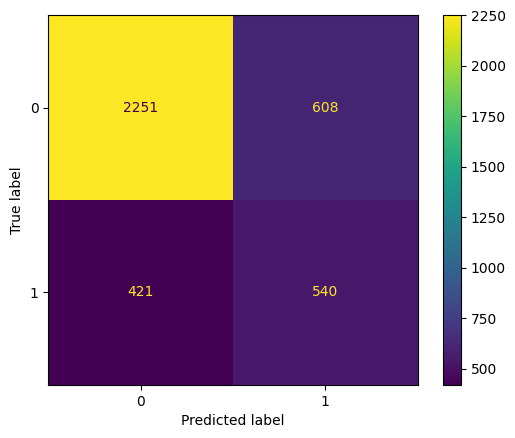

-------------------------
ROC


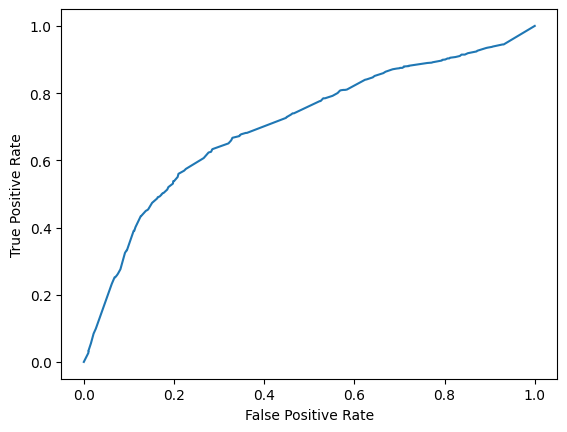

In [309]:
dtc_over_prediction=fit_predict(dtc_over,X_train_over_enc,y_train_over,X_test_enc,y_test)

In [311]:
featureImp(dtc_over)

,importance
city_development_index,0.620739
training_hours,0.083745
relevent_experience,0.066281
experience,0.055346
major_discipline,0.042800
company_type,0.038836
last_new_job,0.028599
company_size,0.024613
enrolled_university,0.020109
education_level,0.012412


### Undersampling

In [312]:
dtc_under = gridSearchFunction(dtc,dtc_parameters,X_train_under_enc,y_train_under)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Best score: 0.7001315789473683
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 6, 'splitter': 'best'}


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2859
           1       0.53      0.53      0.53       961

    accuracy                           0.76      3820
   macro avg       0.68      0.69      0.68      3820
weighted avg       0.76      0.76      0.76      3820

-------------------------
Confusion Matrix


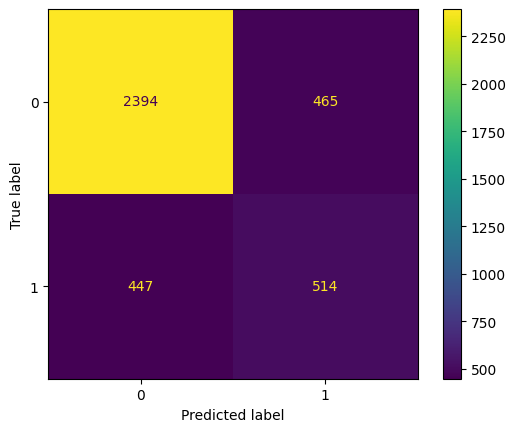

-------------------------
ROC


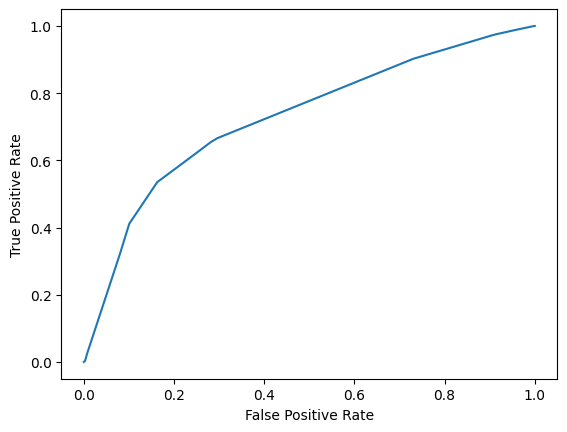

In [313]:
dtc_under_prediction=fit_predict(dtc_under,X_train_under_enc,y_train_under,X_test_enc,y_test)


In [315]:
featureImp(dtc_under)

,importance
city_development_index,0.728381
relevent_experience,0.139117
education_level,0.064196
enrolled_university,0.034184
last_new_job,0.023249
training_hours,0.008050
company_size,0.002823
gender,0.000000
major_discipline,0.000000
experience,0.000000


## Random Forest


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

The set of parameters chosen for the parameter tuning process is similar to the one chosen for the Decision Tree. This is because Random Forest is a meta estimator that fits a number of Decision Tree classifiers on various subsamples of the dataset and uses averaging to improve the predictive accuracy and control overfitting. The only new parameter introduced here is **n_estimators** that represent the number of trees in the forest.

In [110]:
rf=RandomForestClassifier(random_state=RANDOM_STATE)
rf_parameters= {
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 7, 9, None],
    "max_features": [6, 8, 10, "sqrt", "log2", None]
}

### Oversampling

In [111]:
rf_over = gridSearchFunction(rf,rf_parameters,X_train_over_enc,y_train_over)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best score: 0.8125629113433993
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2859
           1       0.46      0.49      0.48       961

    accuracy                           0.73      3820
   macro avg       0.64      0.65      0.65      3820
weighted avg       0.73      0.73      0.73      3820

-------------------------
Confusion Matrix


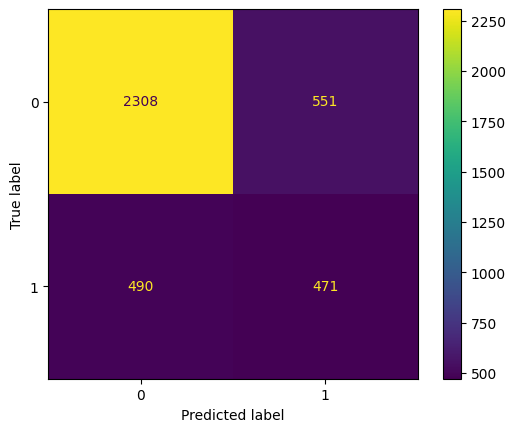

-------------------------
ROC


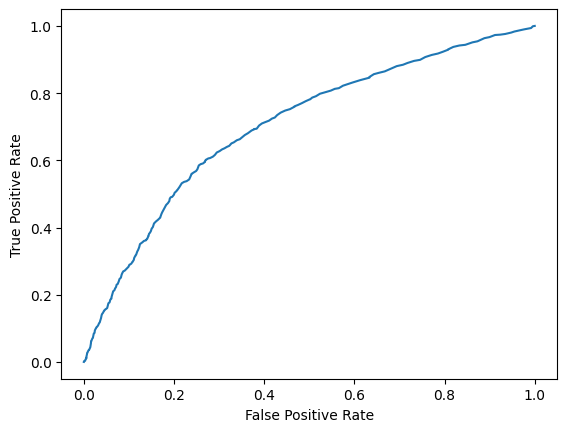

In [112]:
rf_over_prediction=fit_predict(rf_over,X_train_over_enc,y_train_over,X_test_enc,y_test)

### Undersampling

In [114]:
rf_under = gridSearchFunction(rf,rf_parameters,X_train_under_enc,y_train_under)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best score: 0.7042105263157894
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 300}


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2859
           1       0.50      0.62      0.55       961

    accuracy                           0.75      3820
   macro avg       0.68      0.70      0.69      3820
weighted avg       0.77      0.75      0.75      3820

-------------------------
Confusion Matrix


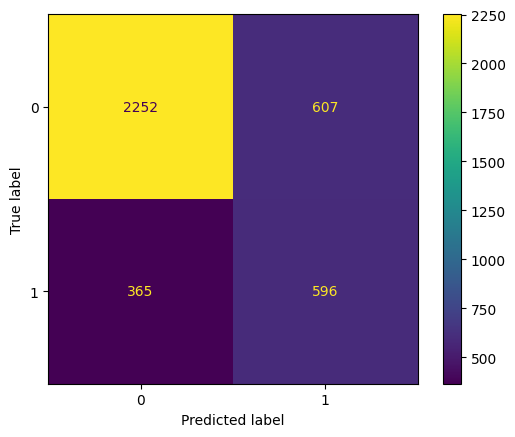

-------------------------
ROC


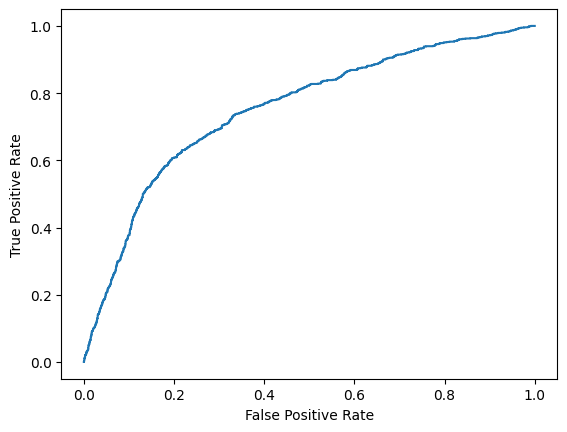

In [115]:
rf_under_prediction=fit_predict(rf_under,X_train_under_enc,y_train_under,X_test_enc,y_test)

## Extra Trees

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

The set of parameters chosen for the parameter tuning process is equal to the one chosen for the Random Forest. This is because Extra Trees fits a number of randomized decision tree classifiers on various subsamples of the dataset and uses averaging, like random forest does, but it introduces two main differences:
1. **Bootstrap** parameter is equal to False by default, thus it performs a sampling without reinsertion (instead in RF in True by default);
2. **Split** is random (instead, RF chooses the best split).


In [117]:
et=ExtraTreesClassifier(random_state=RANDOM_STATE)
et_parameters= {
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 7, 9, None],
    "max_features": [6, 8, 10, "sqrt", "log2", None],
}

### Oversampling

In [118]:
et_over = gridSearchFunction(et,et_parameters,X_train_over_enc,y_train_over)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score: 0.8103842241503647
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2859
           1       0.43      0.43      0.43       961

    accuracy                           0.71      3820
   macro avg       0.62      0.62      0.62      3820
weighted avg       0.71      0.71      0.71      3820

-------------------------
Confusion Matrix


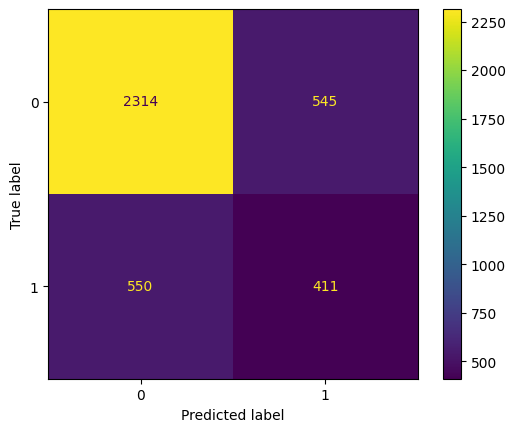

-------------------------
ROC


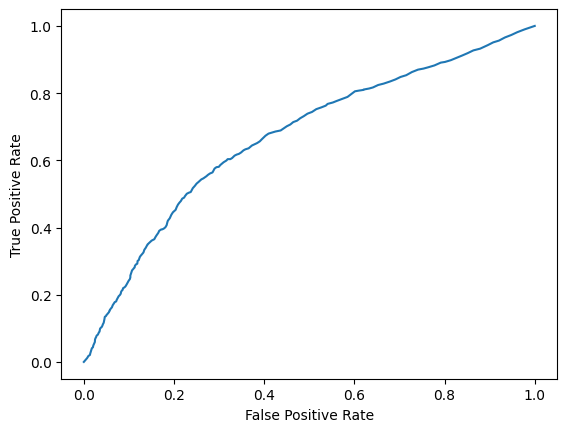

In [119]:
et_over_prediction=fit_predict(et_over,X_train_over_enc,y_train_over,X_test_enc,y_test)

### Undersampling

In [121]:
et_under = gridSearchFunction(et,et_parameters,X_train_under_enc,y_train_under)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best score: 0.7036842105263157
Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 10, 'n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2859
           1       0.49      0.63      0.55       961

    accuracy                           0.74      3820
   macro avg       0.68      0.70      0.69      3820
weighted avg       0.77      0.74      0.75      3820

-------------------------
Confusion Matrix


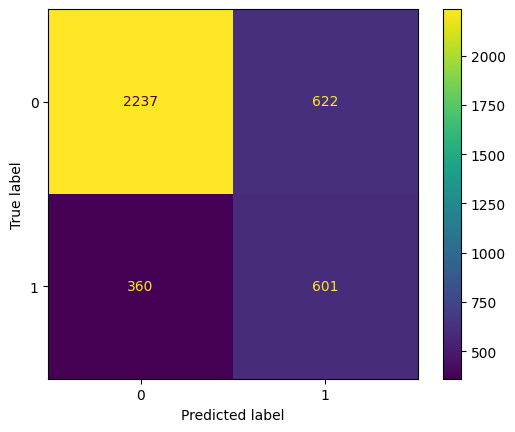

-------------------------
ROC


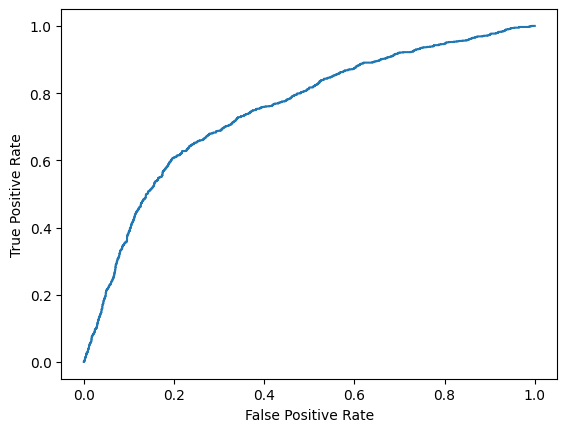

In [122]:
et_under_prediction=fit_predict(et_under,X_train_under_enc,y_train_under,X_test_enc,y_test)

## XGBoost

https://xgboost.readthedocs.io/en/stable/parameter.html#general-parameters

The Extreme Gradient Boosting is a decision tree based machine learning algorithm which uses a process called **boosting** to help improve performances. 

The set of parameters chosen for the parameter tuning process is:
- **gamma**, that is the minimum loss reduction required to make a further partition on a leaf node of the tree;
- **learning_rate**, also called eta, that is the step size shrinkage used in update to prevent overfitting ;
- **max_depth**.

Instead, the others are set by default.


In [124]:
xgb = XGBClassifier()
xgb_parameters= {
    'gamma': [0, 0.7, 1.5],
    'learning_rate': [0.1, 0.3],
    'max_depth': [5, 6, 8]
}


### Oversampling

In [125]:
xgb_over = gridSearchFunction(xgb,xgb_parameters,X_train_over_enc,y_train_over)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.825592903828198
Best parameters: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 8}


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2859
           1       0.51      0.46      0.48       961

    accuracy                           0.75      3820
   macro avg       0.66      0.65      0.66      3820
weighted avg       0.74      0.75      0.75      3820

-------------------------
Confusion Matrix


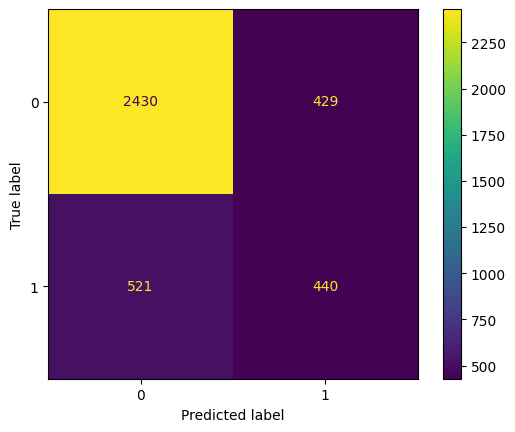

-------------------------
ROC


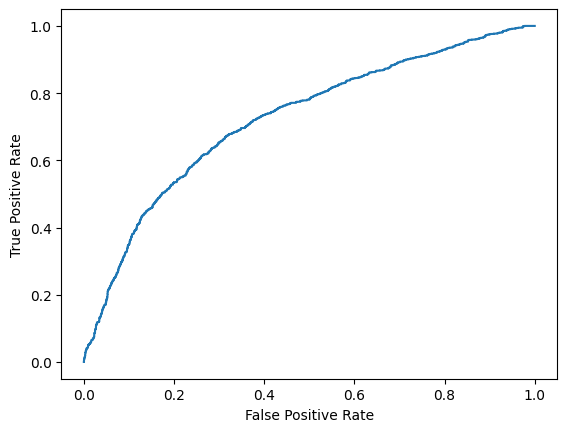

In [126]:
xgb_over_prediction=fit_predict(xgb_over,X_train_over_enc,y_train_over,X_test_enc,y_test)

### Undersampling

In [128]:
xgb_under = gridSearchFunction(xgb,xgb_parameters,X_train_under_enc,y_train_under)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.7056578947368422
Best parameters: {'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 5}


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2859
           1       0.48      0.64      0.55       961

    accuracy                           0.73      3820
   macro avg       0.67      0.70      0.68      3820
weighted avg       0.77      0.73      0.74      3820

-------------------------
Confusion Matrix


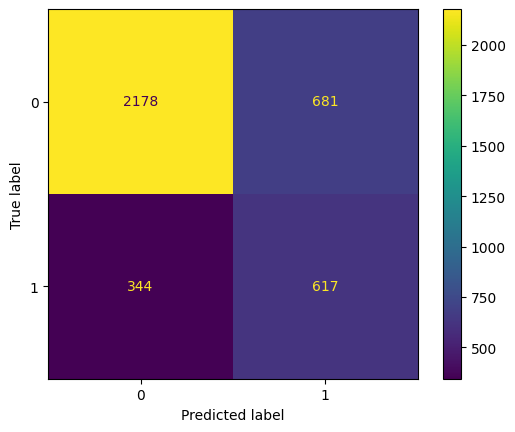

-------------------------
ROC


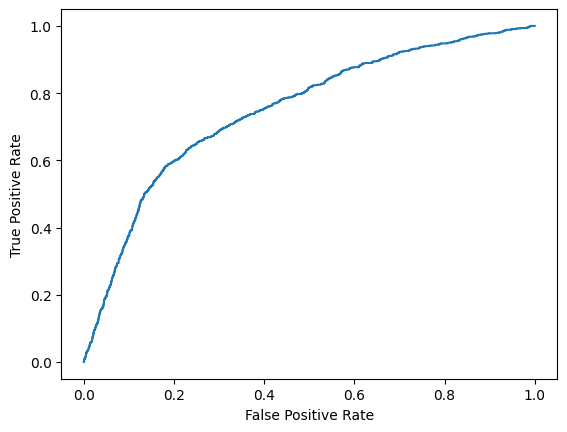

In [129]:
xgb_under_prediction=fit_predict(xgb_under,X_train_under_enc,y_train_under,X_test_enc,y_test)

## Support Vector Machine

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Support Vector Classifier is a supervised machine learning algorithm which works by mapping data points to a high-dimensional space and then finding the optimal hyperplane that divides data into two classes. Kernels are used to make non-separable data into separable data. 

The set of parameters chosen for the parameter tuning process is:
- **C**, that is the regularization parameter;
- **kernel**, that specifies the kernel type to be used in the algorithm.


In [ ]:
svm=SVC(random_state=RANDOM_STATE,probability=True)
svm_parameters= {
    'C': [0.1, 1.0, 10.0],
    #più è grande C e meno support vector avrò (iperpiano hard meno robusto alla presenza di rumore)
    #più è piccolo C e più support vector avrò (iperpiano soft più robusto alla presenza di rumore ma 
    #con maggior rischio di prendere in considerazione punti poco importanti)
    'kernel': ['linear','rbf'],
}

### Oversampling

In [ ]:
svm_over = gridSearchFunction(svm,svm_parameters,X_train_over_enc,y_train_over)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.7048281941502889
Best parameters: {'C': 10.0, 'kernel': 'rbf'}


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2859
           1       0.48      0.58      0.53       961

    accuracy                           0.74      3820
   macro avg       0.67      0.69      0.67      3820
weighted avg       0.76      0.74      0.75      3820

-------------------------
Confusion Matrix


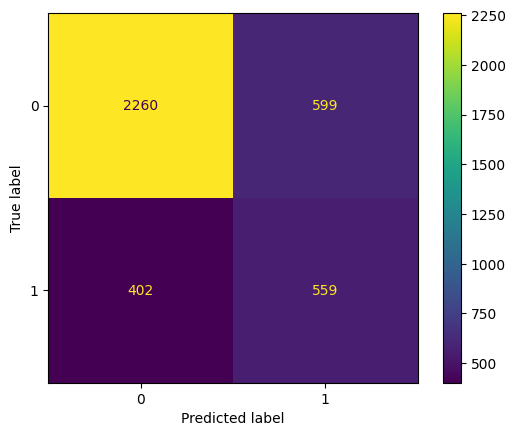

-------------------------
ROC


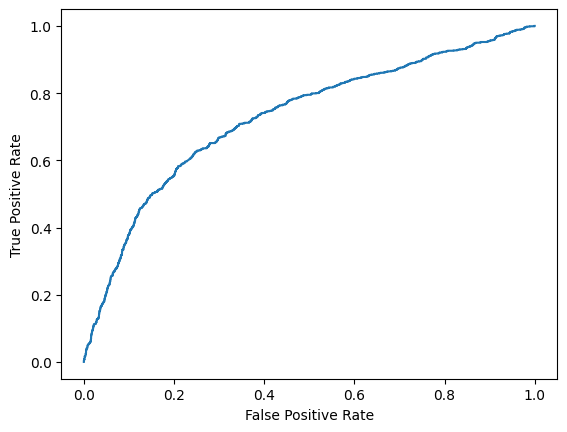

In [ ]:
svm_over_prediction=fit_predict(svm_over,X_train_over_enc,y_train_over,X_test_enc,y_test)

### Undersampling

In [ ]:
svm_under = gridSearchFunction(svm,svm_parameters,X_train_under_enc,y_train_under)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best score: 0.6939473684210526
Best parameters: {'C': 10.0, 'kernel': 'rbf'}


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2859
           1       0.46      0.62      0.53       961

    accuracy                           0.72      3820
   macro avg       0.66      0.69      0.67      3820
weighted avg       0.76      0.72      0.74      3820

-------------------------
Confusion Matrix


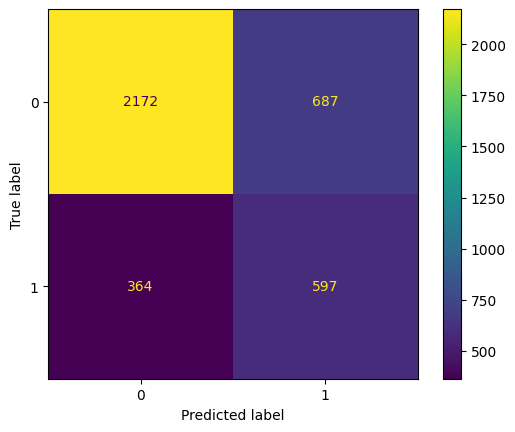

-------------------------
ROC


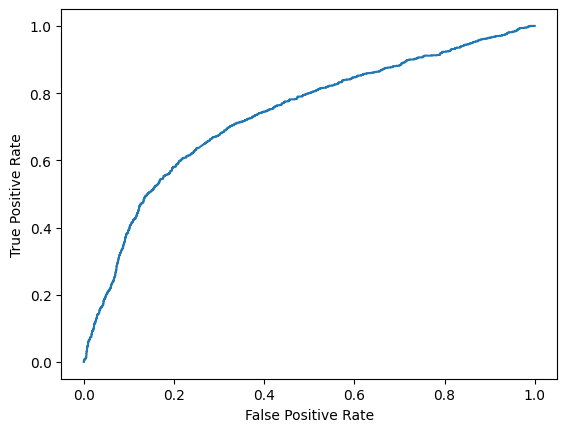

In [ ]:
svm_under_prediction=fit_predict(svm_under,X_train_under_enc,y_train_under,X_test_enc,y_test)

## Neural Networks

The feature encoding previously applied to data, that consists of assigning an integer to each possible category, has the disadvantage that the numeric values can be misunderstood by some algorithms as the higher-level information is lost in translation. This issue can be addressed by another approach called **Dummy Encoding** that creates a number of dummy variables that is equal to the number of categories k minus 1 for each feature. 

In [89]:
X_train_over_dummy=pd.get_dummies(X_train_over,drop_first=True)
X_train_under_dummy=pd.get_dummies(X_train_under,drop_first=True)


X_test_dummy=pd.get_dummies(X_test,drop_first=True)

After that, the feature number has been increased to 54.


In [90]:
X_train_over_dummy.shape

(22956, 54)

In [91]:
X_train_under_dummy.shape

(7600, 54)

In [92]:
def fitting(model,X_train,y_train):
  training_phase = model.fit(
      X_train,
      y_train,
      epochs=100,
      batch_size=BATCH_SIZE,
      validation_split=0.2,
      verbose=1,
  )
  # plot training history
  print("loss")
  plt.plot(training_phase.history["loss"], label="train")
  plt.plot(training_phase.history["val_loss"], label="validation")
  plt.legend()
  plt.show()
  print("Accuracy")
  plt.plot(training_phase.history["accuracy"], label="train")
  plt.plot(training_phase.history["val_accuracy"], label="validation")
  plt.legend()
  plt.show()

In [93]:
def neural_prediction(model,X_test,y_test):
  y_pred = model.predict(X_test)
  y_predicted = np.round(y_pred).astype(int)

  accuracy=accuracy_score(y_test, y_predicted)
  recall=recall_score(y_test, y_predicted)
  cm=confusion_matrix(y_test, y_predicted)
  specificity=cm[0,0]/(cm[0,1]+cm[0,0])
  precision=precision_score(y_test, y_predicted)
  F1_score=f1_score(y_test, y_predicted)
  AUC_score=roc_auc_score(y_test,y_pred)#area under ROC curve

  print("Classification Report:")
  print(classification_report(y_test, y_predicted))

  print("-------------------------")
  print("Confusion Matrix")
  f = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predicted)).plot()
  plt.show()
  plt.close()

  print("-------------------------")
  print("ROC")
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
  plt.show()
  plt.close()
  

  return [accuracy,recall,specificity,precision,F1_score,AUC_score]

To easily implement a neural network, **Keras** was used. It’s a deep learning API written in Python, running on the top of the machine learning platform Tensorflow. 

### Oversampling

There is another aspect to take into consideration: overfitting. Overfitting happens when the model learns too many details from the training set while its performance is poor on unseen samples: it fails to generalize the features or patterns in the training set. There are several techniques to prevent this issue. Here the idea is to combine L2 regularization with dropout.

- **L2** updates the loss function by adding the regularization term (= sum over all squared weight values of the weight matrix)
- **Dropout** drops out some nodes in a neural network, based on a probability, so that all the forward and backwards connections with a dropped node are temporarily removed

In [98]:
# Initialize the constructor
nn_over = Sequential()
# Add an input layer
nn_over.add(Input(shape=(54,)))
nn_over.add(Dense(50, activation="relu"))
nn_over.add(Dropout(0.2))
# Add one hidden layer
nn_over.add(Dense(30, activation="relu",kernel_regularizer=l2(0.01)))
nn_over.add(Dropout(0.5))
# Add an output layer
nn_over.add(Dense(1, activation="sigmoid"))

nn_over.compile(
    loss="binary_crossentropy",
    optimizer="adam",#SGD
    metrics=["accuracy", tf.keras.metrics.AUC()],
)

nn_over.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                2750      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 30)                1530      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,311
Trainable params: 4,311
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
574/574 [==============================] - 4s 5ms/step - loss: 0.7138 - accuracy: 0.6928 - auc_1: 0.6991 - val_loss: 0.7974 - val_accuracy: 0.5096 - val_auc_1: 0.0000e+00
Epoch 2/100
574/574 [==============================] - 3s 5ms/step - loss: 0.5889 - accuracy: 0.7211 - auc_1: 0.7394 - val_loss: 0.7816 - val_accuracy: 0.5494 - val_auc_1: 0.0000e+00
Epoch 3/100
574/574 [==============================] - 2s 3ms/step - loss: 0.5763 - accuracy: 0.7274 - auc_1: 0.7472 - val_loss: 0.7324 - val_accuracy: 0.5917 - val_auc_1: 0.0000e+00
Epoch 4/100
574/574 [==============================] - 2s 3ms/step - loss: 0.5713 - accuracy: 0.7313 - auc_1: 0.7527 - val_loss: 0.7385 - val_accuracy: 0.5830 - val_auc_1: 0.0000e+00
Epoch 5/100
574/574 [==============================] - 2s 3ms/step - loss: 0.5700 - accuracy: 0.7315 - auc_1: 0.7546 - val_loss: 0.7512 - val_accuracy: 0.5708 - val_auc_1: 0.0000e+00
Epoch 6/100
574/574 [==============================] - 2s 3ms/step - loss: 0.5655 - a

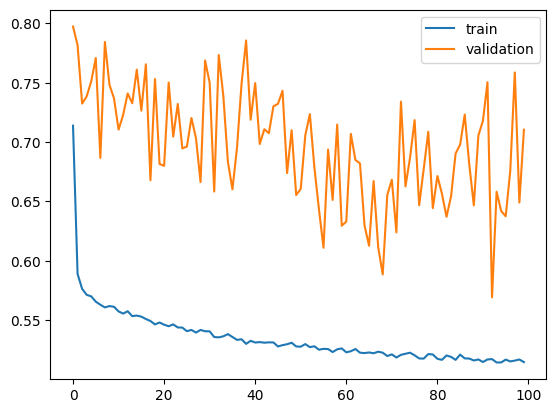

Accuracy


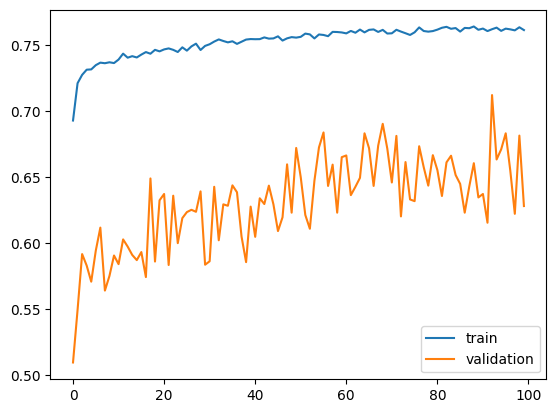

In [99]:
fitting(nn_over,X_train_over_dummy,y_train_over)

120/120 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      2859
           1       0.50      0.49      0.50       961

    accuracy                           0.75      3820
   macro avg       0.67      0.67      0.67      3820
weighted avg       0.75      0.75      0.75      3820

-------------------------
Confusion Matrix


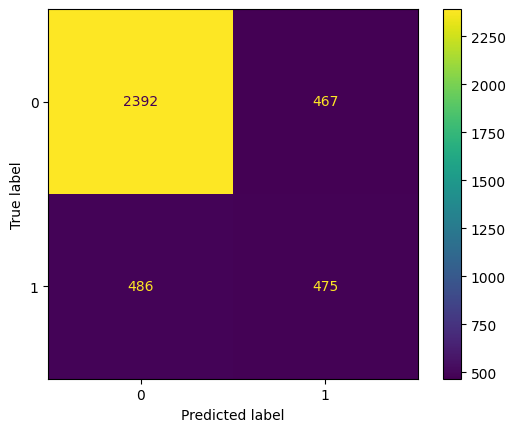

-------------------------
ROC


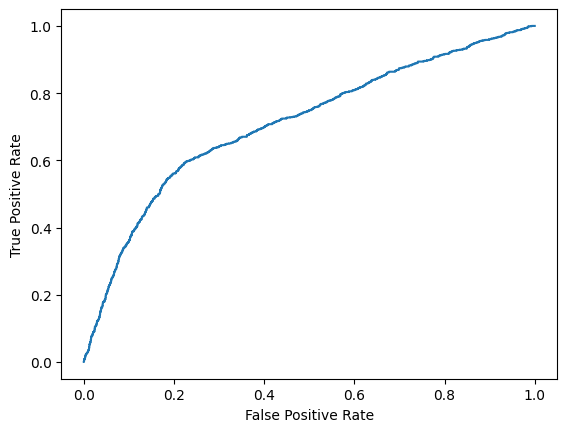

In [100]:
nn_over_prediction=neural_prediction(nn_over,X_test_dummy,y_test)

### Undersampling


Since the undersampled training set consists of around 8000 records, the number of nodes was reduced with respect to the one used for the oversampled case to decrease the amount of parameters. The new neural network has 15 neurons in the first hidden layer and 10 in the second, leading to a number of trainable parameters equal to 996.

In [106]:
nn_under = Sequential()
# Add an input layer
nn_under.add(Dense(15, activation="relu", input_shape=(54,)))
nn_under.add(Dropout(0.2))
# Add one hidden layer
nn_under.add(Dense(10, activation="relu",kernel_regularizer=l2(0.01)))
nn_under.add(Dropout(0.5))
# Add an output layer
nn_under.add(Dense(1, activation="sigmoid"))

nn_under.compile(
    loss="binary_crossentropy",
    optimizer="adam",#SGD
    metrics=["accuracy", tf.keras.metrics.AUC()],
)

nn_under.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 15)                825       
                                                                 
 dropout_4 (Dropout)         (None, 15)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                160       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 996
Trainable params: 996
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
190/190 [==============================] - 3s 6ms/step - loss: 0.6715 - accuracy: 0.6222 - auc_3: 0.5786 - val_loss: 0.8602 - val_accuracy: 0.2882 - val_auc_3: 0.0000e+00
Epoch 2/100
190/190 [==============================] - 1s 3ms/step - loss: 0.6402 - accuracy: 0.6707 - auc_3: 0.6479 - val_loss: 0.8740 - val_accuracy: 0.4211 - val_auc_3: 0.0000e+00
Epoch 3/100
190/190 [==============================] - 1s 3ms/step - loss: 0.6289 - accuracy: 0.6808 - auc_3: 0.6696 - val_loss: 0.8574 - val_accuracy: 0.4638 - val_auc_3: 0.0000e+00
Epoch 4/100
190/190 [==============================] - 1s 3ms/step - loss: 0.6167 - accuracy: 0.6875 - auc_3: 0.6909 - val_loss: 0.8699 - val_accuracy: 0.4645 - val_auc_3: 0.0000e+00
Epoch 5/100
190/190 [==============================] - 1s 3ms/step - loss: 0.6093 - accuracy: 0.6910 - auc_3: 0.7010 - val_loss: 0.8610 - val_accuracy: 0.4862 - val_auc_3: 0.0000e+00
Epoch 6/100
190/190 [==============================] - 1s 3ms/step - loss: 0.6044 - a

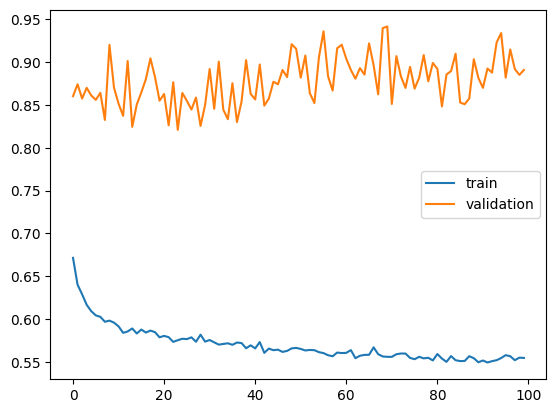

Accuracy


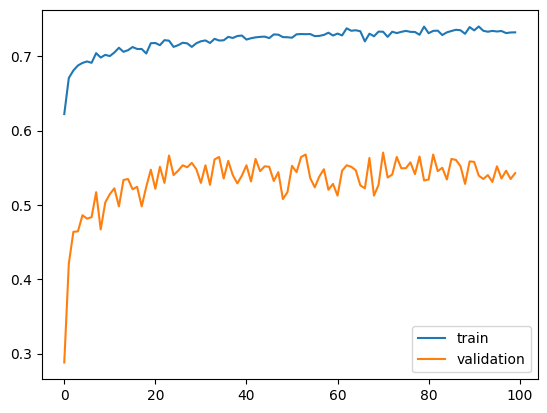

In [107]:
fitting(nn_under,X_train_under_dummy,y_train_under)

120/120 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2859
           1       0.50      0.54      0.52       961

    accuracy                           0.75      3820
   macro avg       0.67      0.68      0.67      3820
weighted avg       0.76      0.75      0.75      3820

-------------------------
Confusion Matrix


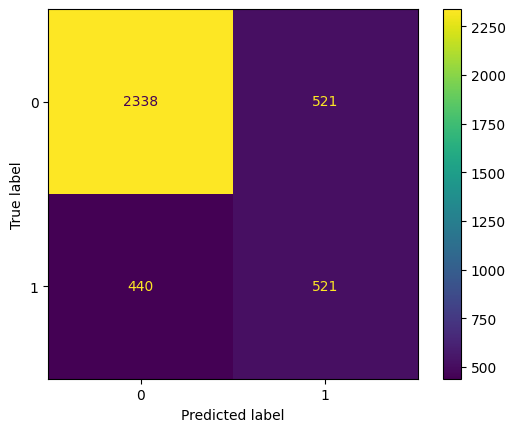

-------------------------
ROC


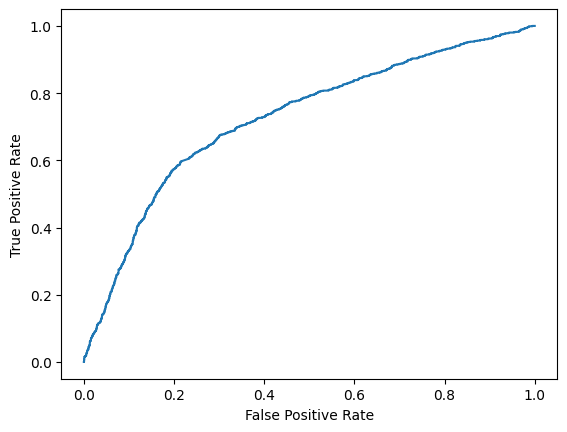

In [108]:
nn_under_prediction=neural_prediction(nn_under,X_test_dummy,y_test)

# Comparison

After the detailed phase of data preprocessing and the training of several classifiers, the results can be easily compared since model performances were computed using the same metrics on the same test set.

In [131]:
def metrics_comparison(predictions):
  df=pd.DataFrame()
  models=['DT','RF','ET','XGB','SVM','NN']
  df['model']=models
  df=df.set_index('model')

  models_accuracy=[]
  models_recall=[]
  models_specificity=[]
  models_precision=[]
  models_f1=[]
  models_auc=[]

  #predictions=[dtc_over_prediction,dtc_under_prediction]
  for pred in predictions:
    models_accuracy=np.append(models_accuracy,pred[0])
    models_recall=np.append(models_recall,pred[1])
    models_specificity=np.append(models_specificity,pred[2])
    models_precision=np.append(models_precision,pred[3])
    models_f1=np.append(models_f1,pred[4])
    models_auc=np.append(models_auc,pred[5])

  metrics=[models_accuracy,models_recall,models_specificity,models_precision,models_f1,models_auc]
  string_metrics=['accuracy','recall','specificity','precision','f1','auc']
  
  for index in range(len(metrics)):
    df[string_metrics[index]]=metrics[index]
  
  return df



### Oversampling


In [134]:
over_predictions=[dtc_over_prediction,rf_over_prediction,et_over_prediction,xgb_over_prediction,svm_over_prediction,nn_over_prediction]
over_table= metrics_comparison(over_predictions)

over_table

,accuracy,recall,specificity,precision,f1,auc
model,,,,,,
DT,0.730628,0.561915,0.787338,0.470383,0.512091,0.705172
RF,0.727487,0.490114,0.807275,0.460861,0.475038,0.703674
ET,0.713351,0.427680,0.809374,0.429916,0.428795,0.669144
XGB,0.751309,0.457856,0.849948,0.506329,0.480874,0.722367
SVM,0.737958,0.581686,0.790486,0.482729,0.527607,0.727560
NN,0.750524,0.494277,0.836656,0.504246,0.499212,0.710175


All classifiers collected very similar results, with an accuracy between 0.71 and 0.75. The one which performs slightly better in terms of accuracy, specificity and precision is XGBoost.

### Undersampling

In [136]:
under_predictions=[dtc_under_prediction,rf_under_prediction,et_under_prediction,xgb_under_prediction,svm_under_prediction,nn_under_prediction]
under_table= metrics_comparison(under_predictions)

under_table

,accuracy,recall,specificity,precision,f1,auc
model,,,,,,
DT,0.761257,0.534860,0.837356,0.525026,0.529897,0.727560
RF,0.745550,0.620187,0.787688,0.495428,0.550832,0.752130
ET,0.742932,0.625390,0.782441,0.491415,0.550366,0.749994
XGB,0.731675,0.642040,0.761805,0.475347,0.546259,0.749272
SVM,0.724869,0.621228,0.759706,0.464953,0.531849,0.734582
NN,0.748429,0.542144,0.817768,0.500000,0.520220,0.724041


All classifiers collected very similar results, with an accuracy between 0.72 and 0.76. The one which performs slightly better in terms of accuracy, specificity and precision is Decision Tree.

Despite the application of data sampling techniques,  all models trained on the oversampled and undersampled datasets predict better the majority class with respect to the minority one. In fact, the results obtained in confusion matrices and in the previous tables show this trend:
- the percentage of correct positive predictions is lower than the one of correct negative predictions
- recall and precision which focus on positive class are usually low
- specificity which focus on negative class is usually high



# Conclusion

Therefore, after the application of a complete set of data preprocessing techniques, such as feature removal, handling of missing values, feature scaling, data sampling and feature encoding, and the training of several models, the performances obtained are almost the same. The best model capables of predicting whether a candidate really wants to work for the company after the training courses or will look for a new job, seems to be the decision tree trained on the undersampled dataset.


In [ ]:
best_model=dtc_under

# Kaggle submission

In conclusion, this model was used to predict target values of those records provided by Kaggle for the submission.


In [ ]:
test_kaggle_enc.drop("target", axis=1) #Remove target column

In [ ]:
pred_submission=best_model.predict(test_kaggle_enc)

submission = pd.DataFrame() #Create a new DataFrame for submission
submission['Id'] = test_kaggle_id
submission['target'] = pred_submission
submission.to_csv("kaggle_submission.csv", index=False)